<a href="https://colab.research.google.com/github/NataliaLimanova/14.05.2025/blob/main/_Credit_Risk_Management_Research_14_05_2025_ipynb_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модель кредитного риск-менеджмента
### *Итоговый проект курса Machine Learning Junior*




<a id="ch002"></a>
## Вступление

Банки используют модели кредитного риск-менеджмента, чтобы понимать,
насколько можно доверять клиенту в выполнении обязательств по договорам
кредитования. Когда вы как клиент заполняете заявку на кредит или ипотеку,
вас оценивают по модели кредитного риск-менеджмента. Банк может
использовать разные сведения: например, о месте работы, возрасте, истории
предыдущих погашений по другим кредитам в банках и кредитных
организациях. На основе этой информации модель машинного обучения
подсказывает кредитному менеджеру, стоит ли вам доверять запрашиваемую
сумму денег.
С помощью такой автоматизации банк экономит время своих специалистов,
чтобы они не искали и не агрегировали информацию по каждому клиенту для
принятия решения о выдаче кредита. Это ускоряет время подтверждения
заявки на кредит. Однако в отдельных случаях специалисты могут экспертно
проверить решение модели, чтобы проаудировать её и выявить возможные
слабые места.
Данный пример рассматривает только одну модель, которая учитывается
в кредитном риск-менеджменте. Помимо неё используют и модели
предсказания суммы кредита/займа, которую сможет оплатить клиент,
и определения текущего рейтинга платёжеспособности клиента, у которого
уже есть кредит. Модели нужны, чтобы спрогнозировать, какие клиенты могут
выйти в просрочку, и предпринять какие-либо препятствующие выдаче
кредита действия.

### Проблема, которую предстоит решить
В рамках итогового проекта необходимо оценить
риск неуплаты клиента по кредиту (дефолт).
Дефолт — неуплата процентов по кредиту или облигациям, непогашение
займа в течение определённого времени t. Обычно дефолт считают
свершившимся, если клиент не совершил выплату по кредиту в течение
90 дней.

Нужная модель позволяет банку или другой кредитной организации оценить
текущий риск по любым выданным займам и кредитным продуктам
и с большей долей вероятности предотвратить неисполнение кредитных
обязательств клиентом. Таким образом, банк меньше рискует понести
убытки.

### Краткое описание задачи
Необходимо создать одну из моделей для оценки кредитного риска —
предсказание выхода клиента в дефолт по кредиту.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Импорт необходимых библиотек
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats
import IPython
from IPython import display

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from imblearn.under_sampling import RandomUnderSampler

import psutil
import time
import inspect
import pyarrow.parquet as pq
import missingno as msno
from imblearn.under_sampling import RandomUnderSampler
plt.style.use('fivethirtyeight')
import random

import warnings
warnings.filterwarnings('ignore')

In [10]:
# Загрузка библиотек моделирования данных

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.plotting import scatter_matrix

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [11]:
# Функция вывод использования памяти
def get_memory_usage(dataframe):
    # Получаем имя переменной, содержащей dataframe
    dataframe_name = [name for name, obj in inspect.currentframe().f_back.f_locals.items() if obj is dataframe][0]

    # Рассчитываем использование памяти
    memory_usage = dataframe.memory_usage(deep=True).sum() / (1024 * 1024)
    memory_usage_rounded = round(memory_usage, 2)

    # Возвращаем информацию о памяти
    return f"File '{dataframe_name}': memory_usage: {memory_usage_rounded} Mb"

# Функция вывод затраченного времени
def measure_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Время выполнения '{func.__name__}': {elapsed_time:.2f} секунд")
    return result

# Функция чтения файла из паркета
def read_file(file_path):
    df = pd.read_parquet(file_path)
    return df

# Функция добавления целевого значения 'flag'
def add_target_column(df, target_file_path):
    target_df = pd.read_csv(target_file_path)
    df = pd.merge(df, target_df[['id', 'flag']], on='id', how='left')
    return df

# Функция для вывода информации о памяти и процессоре
def print_system_info():
    memory = psutil.virtual_memory()
    cpu_load = psutil.cpu_percent(interval=1)
    print(f"Занято ОЗУ: {memory.used / (1024 ** 3):.2f} GB")
    print(f"Свободно ОЗУ: {memory.available / (1024 ** 3):.2f} GB")
    print(f"Нагрузка на процессор: {cpu_load:.2f}%")

# Функция графиков сравнения распределений признаков по flag
def plot_distribution(data, feature, flag_column='flag', bins=20, figsize=(10, 6)):
    # Создаем новый график с заданным размером
    plt.figure(figsize=figsize)

    # Фильтруем строки, где flag равен 1
    flag_1_data = data[data[flag_column] == 1]

    # Фильтруем строки, где flag равен 0
    flag_0_data = data[data[flag_column] == 0]

    # Построение гистограммы для столбца feature для flag=1 (синий цвет)
    plt.hist(flag_1_data[feature], bins=bins, color='blue', alpha=0.5, label='flag=1')

    # Построение гистограммы для столбца feature для flag=0 (красный цвет)
    plt.hist(flag_0_data[feature], bins=bins, color='red', alpha=0.5, label='flag=0')

    # Добавление легенды, заголовка и подписей осей
    plt.legend()
    plt.title(f'Распределение {feature}')
    plt.xlabel(feature)
    plt.ylabel('Частота')

    # Показать график
    plt.show()


# Функция агрегации по id и вычисления МЕДИАНЫ
def process_data(merged_data):
    # Разделение DataFrame на две части
    data_flag1 = merged_data[merged_data['flag'] == 1]
    data_flag0 = merged_data[merged_data['flag'] == 0]

    # Агрегация данных с flag=0
    # Предполагаем, что все остальные колонки кроме 'id' и 'flag' - числовые
    aggregated_data = data_flag0.groupby('id').median().reset_index()

    # Добавляем колонку flag, так как медиана удалит её
    aggregated_data['flag'] = 0

    # Объединение данных с flag=1 и агрегированных данных с flag=0
    final_data = pd.concat([data_flag1, aggregated_data], ignore_index=True)

    return final_data


# Функция cоздания графиков распределения
def plot_categorical_distributions(data, categorical_features, flag_column='flag', cols=2):
    # Определяем количество графиков в строке
    num_rows = (len(categorical_features) + cols - 1) // cols

    # Создаем фигуру и оси
    fig, axes = plt.subplots(num_rows, cols, figsize=(cols * 8, num_rows * 6), constrained_layout=True)

    # Преобразуем оси в массив, если это необходимо
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    # Обходим все признаки и создаем графики
    for i, feature in enumerate(categorical_features):
        ax = axes[i // cols, i % cols]

        # Фильтруем данные по флагу
        flag_0_data = data[data[flag_column] == 0][feature]
        flag_1_data = data[data[flag_column] == 1][feature]

        # Настройки гистограммы
        bins = np.linspace(min(data[feature]), max(data[feature]), 15)

        # Подготовка данных для гистограмм
        hist0, bins0 = np.histogram(flag_0_data, bins=bins)
        hist1, bins1 = np.histogram(flag_1_data, bins=bins)

        # Нормализация ширины бинов для отображения в bar plot
        width = np.diff(bins0).min()

        # Рисуем гистограммы
        rects1 = ax.bar(bins0[:-1], hist0, width=width, align='center', alpha=0.5, label='Flag 0', color='blue')
        rects2 = ax.bar(bins1[:-1] + width, hist1, width=width, align='center', alpha=0.5, label='Flag 1', color='red')

        # Добавляем названия и метки
        ax.set_title(f'Distribution of {feature} by Flag')
        ax.set_xlabel(feature)
        ax.set_ylabel('Frequency')
        ax.legend()

        # Функция для добавления процентов на столбцы
        def autolabel(rects, total):
            for rect in rects:
                height = rect.get_height()
                if height > 0:  # Добавляем аннотацию только если высота столбца больше 0
                    ax.annotate(f'{height/total:.2%}',
                                xy=(rect.get_x() + rect.get_width() / 2, height),
                                xytext=(0, 3),  # смещение метки на 3 пункта вверх
                                textcoords="offset points",
                                ha='center', va='bottom')

        # Применяем функцию autolabel для добавления процентов
        autolabel(rects1, len(flag_0_data))
        autolabel(rects2, len(flag_1_data))

    # Убираем ненужные оси
    for i in range(len(categorical_features), len(axes.flat)):
        fig.delaxes(axes.flatten()[i])

    # Показываем графики
    plt.show()



Скачаем один файл для изучения из паркета `train_data/train_data_1.pq` и соединим с целевой из файла `train_target.csv`

In [12]:
target_file_path = "/content/train_target.csv"
file_path = '/content/train_data_1.pq'
# Используем measure_time для измерения времени чтения файла
merged_data_1 = measure_time(read_file, file_path)

# Используем measure_time для измерения времени добавления столбца с таргетом
merged_data_1 = measure_time(add_target_column, merged_data_1, target_file_path)

Время выполнения 'read_file': 2.12 секунд
Время выполнения 'add_target_column': 1.07 секунд


<a id="ch004"></a>
## Решение проблемы нехватки ОЗУ при работе с big data


In [13]:

get_memory_usage(merged_data_1)

"File 'merged_data_1': memory_usage: 996.8 Mb"

In [14]:
merged_data_1.shape

(2107305, 62)

In [15]:
merged_data_1.dtypes

id                       int64
rn                       int64
pre_since_opened         int64
pre_since_confirmed      int64
pre_pterm                int64
                         ...  
enc_loans_credit_type    int64
enc_loans_account_cur    int64
pclose_flag              int64
fclose_flag              int64
flag                     int64
Length: 62, dtype: object

In [16]:
merged_data_int8 = merged_data_1.copy()

In [17]:
# Создаем список столбцов для преобразования, исключая 'id'
columns_to_convert = merged_data_int8.columns.drop('id')

# Преобразуем выбранные столбцы в тип данных int8
merged_data_int8[columns_to_convert] = merged_data_int8[columns_to_convert].astype('int8')


In [18]:
merged_data_int8.dtypes

id                       int64
rn                        int8
pre_since_opened          int8
pre_since_confirmed       int8
pre_pterm                 int8
                         ...  
enc_loans_credit_type     int8
enc_loans_account_cur     int8
pclose_flag               int8
fclose_flag               int8
flag                      int8
Length: 62, dtype: object

In [19]:
get_memory_usage(merged_data_int8)

"File 'merged_data_int8': memory_usage: 138.67 Mb"

Теперь датафрейм стал "легче"

<a id="ch005"></a>
## Высвобождение ресурсов ОЗУ


In [20]:
processes = []
for proc in psutil.process_iter(['pid', 'name', 'memory_info']):
    try:
        mem_info = proc.info['memory_info']
        processes.append((proc.info['name'], proc.info['pid'], mem_info.rss))
    except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
        pass

processes.sort(key=lambda x: x[2], reverse=True)

for name, pid, rss in processes:
    print(f"Процесс: {name}, PID: {pid}, RSS: {rss / (1024 ** 2):.2f} MB")


Процесс: python3, PID: 1561, RSS: 3567.37 MB
Процесс: node, PID: 1625, RSS: 421.66 MB
Процесс: colab-fileshim., PID: 73, RSS: 221.11 MB
Процесс: jupyter-noteboo, PID: 90, RSS: 128.07 MB
Процесс: node, PID: 6, RSS: 76.40 MB
Процесс: drive, PID: 1844, RSS: 73.52 MB
Процесс: drive, PID: 1730, RSS: 37.54 MB
Процесс: language_service, PID: 1618, RSS: 23.67 MB
Процесс: python3, PID: 1589, RSS: 20.17 MB
Процесс: kernel_manager_proxy, PID: 19, RSS: 15.55 MB
Процесс: python3, PID: 1929, RSS: 12.87 MB
Процесс: dap_multiplexer, PID: 91, RSS: 9.06 MB
Процесс: directoryprefetcher_binary, PID: 1927, RSS: 3.45 MB
Процесс: oom_monitor.sh, PID: 14, RSS: 3.35 MB
Процесс: bash, PID: 1926, RSS: 3.07 MB
Процесс: run.sh, PID: 16, RSS: 1.86 MB
Процесс: grep, PID: 1731, RSS: 1.57 MB
Процесс: bash, PID: 1728, RSS: 1.46 MB
Процесс: tail, PID: 1928, RSS: 1.04 MB
Процесс: sleep, PID: 2654, RSS: 1.03 MB
Процесс: tail, PID: 38, RSS: 0.97 MB
Процесс: tail, PID: 44, RSS: 0.97 MB
Процесс: docker-init, PID: 1, RSS: 0.0

In [21]:
dataframes = [obj for obj in globals().values() if isinstance(obj, pd.DataFrame)]

total_memory_usage = 0
for df in dataframes:
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # перевод в мбайты
    total_memory_usage += memory_usage

print("Общее использование памяти всех датафреймов: {:.2f} MB".format(total_memory_usage))


Общее использование памяти всех датафреймов: 1135.47 MB


In [22]:
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # перевод в мб
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'merged_data_1' использует 996.80 MB памяти
Датафрейм 'merged_data_int8' использует 138.67 MB памяти
Датафрейм 'df' использует 138.67 MB памяти


In [23]:
# Высвобождение памяти, занятой переменными, кроме 'merged_data_int8'
del merged_data_1, df,


In [24]:
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'merged_data_int8' использует 138.67 MB памяти


In [25]:
dataframes = [obj for obj in globals().values() if isinstance(obj, pd.DataFrame)]

total_memory_usage = 0
for df in dataframes:
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)
    total_memory_usage += memory_usage

print("Общее использование памяти всех датафреймов: {:.2f} MB".format(total_memory_usage))


Общее использование памяти всех датафреймов: 277.34 MB


<a id="ch006"></a>
## Разведочный анализ данных.



In [26]:
# Среднее
df_mean = merged_data_int8.groupby('id').mean().reset_index()

In [27]:
df_mean.shape

(250000, 62)

In [28]:
df_mean.flag.value_counts()

flag
0.0    241788
1.0      8212
Name: count, dtype: int64

In [29]:
df_mean.describe()

id             rn  pre_since_opened  pre_since_confirmed  \
count  250000.000000  250000.000000     250000.000000        250000.000000   
mean   374999.500000       4.714610          9.278846             8.348807   
std     72168.927986       2.980943          2.906726             2.310306   
min    250000.000000       1.000000          0.000000             0.000000   
25%    312499.750000       2.500000          7.600000             7.000000   
50%    374999.500000       4.000000          9.227273             8.500000   
75%    437499.250000       6.500000         10.857143             9.640000   
max    499999.000000      25.500000         19.000000            17.000000   

           pre_pterm      pre_fterm  pre_till_pclose  pre_till_fclose  \
count  250000.000000  250000.000000    250000.000000    250000.000000   
mean        8.201756       8.328779         6.831534         8.627059   
std         2.709297       2.036352         2.648436         1.943026   
min         0.000000       0.000000         0.000000         0.000000   
25%         6.600000       7.214286         5.400000         7.444444   
50%         8.272727       8.250000         7.000000         8.600000   
75%         9.800000       9.500000         8.375000        10.000000   
max        17.000000      16.000000        16.000000        15.000000   

       pre_loans_credit_limit  pre_loans_next_pay_summ  ...    enc_paym_22  \
count           250000.000000            250000.000000  ...  250000.000000   
mean                 9.717652                 2.448215  ...       2.346913   
std                  2.914558                 0.785479  ...       0.636230   
min                  0.000000                 0.000000  ...       0.000000   
25%                  8.000000                 2.000000  ...       2.000000   
50%                  9.750000                 2.333333  ...       2.437500   
75%                 11.380952                 2.764706  ...       3.000000   
max                 19.000000                 6.000000  ...       3.000000   

         enc_paym_23    enc_paym_24  enc_loans_account_holder_type  \
count  250000.000000  250000.000000                  250000.000000   
mean        2.379168       3.572032                       1.033721   
std         0.623512       0.531023                       0.173891   
min         0.000000       1.000000                       0.800000   
25%         2.000000       3.307692                       1.000000   
50%         2.500000       3.705882                       1.000000   
75%         3.000000       4.000000                       1.000000   
max         3.000000       4.000000                       6.000000   

       enc_loans_credit_status  enc_loans_credit_type  enc_loans_account_cur  \
count            250000.000000          250000.000000          250000.000000   
mean                  2.605997               3.261472               1.002414   
std                   0.287920               0.573640               0.030775   
min                   1.000000               0.000000               0.000000   
25%                   2.500000               3.000000               1.000000   
50%                   2.666667               3.333333               1.000000   
75%                   2.800000               3.625000               1.000000   
max                   5.000000               5.000000               2.000000   

         pclose_flag    fclose_flag           flag  
count  250000.000000  250000.000000  250000.000000  
mean        0.194329       0.293668       0.032848  
std         0.221341       0.253212       0.178239  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.125000       0.000000  
50%         0.142857       0.250000       0.000000  
75%         0.272727       0.400000       0.000000  
max         1.000000       1.000000       1.000000  

[8 rows x 62 columns]

In [30]:
# Удалим столбцы 'id' и 'rn'
df = merged_data_int8.drop(['id', 'rn'], axis=1)

# Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']

Классификационный отчет:
               precision    recall  f1-score   support

           0       0.98      0.62      0.76    408915
           1       0.04      0.57      0.08     12546

    accuracy                           0.62    421461
   macro avg       0.51      0.59      0.42    421461
weighted avg       0.95      0.62      0.74    421461

Confusion Matrix:
 [[253065 155850]
 [  5441   7105]]
ROC AUC: 0.6276642208802246


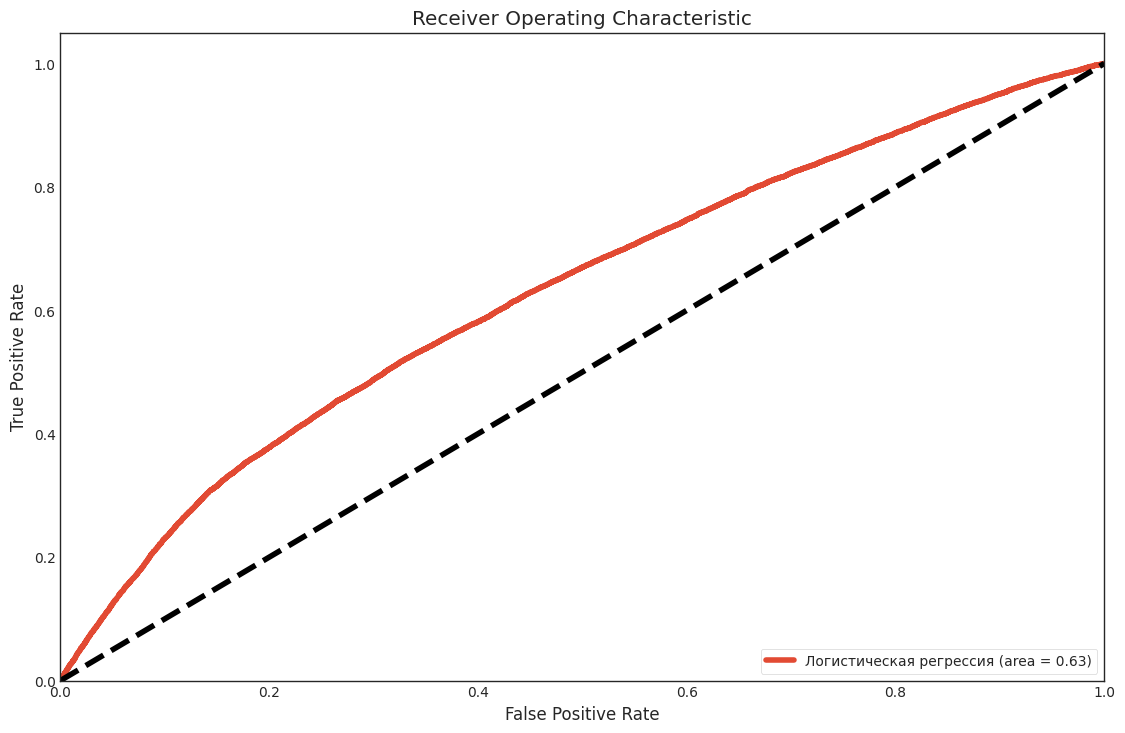

In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Классификационный отчет:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая регрессия (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Классификационный отчет для XGBoost:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97    408915
           1       0.11      0.15      0.13     12546

    accuracy                           0.94    421461
   macro avg       0.54      0.56      0.55    421461
weighted avg       0.95      0.94      0.94    421461

Confusion Matrix для XGBoost:
 [[393356  15559]
 [ 10642   1904]]
ROC AUC для XGBoost: 0.6641219547846423


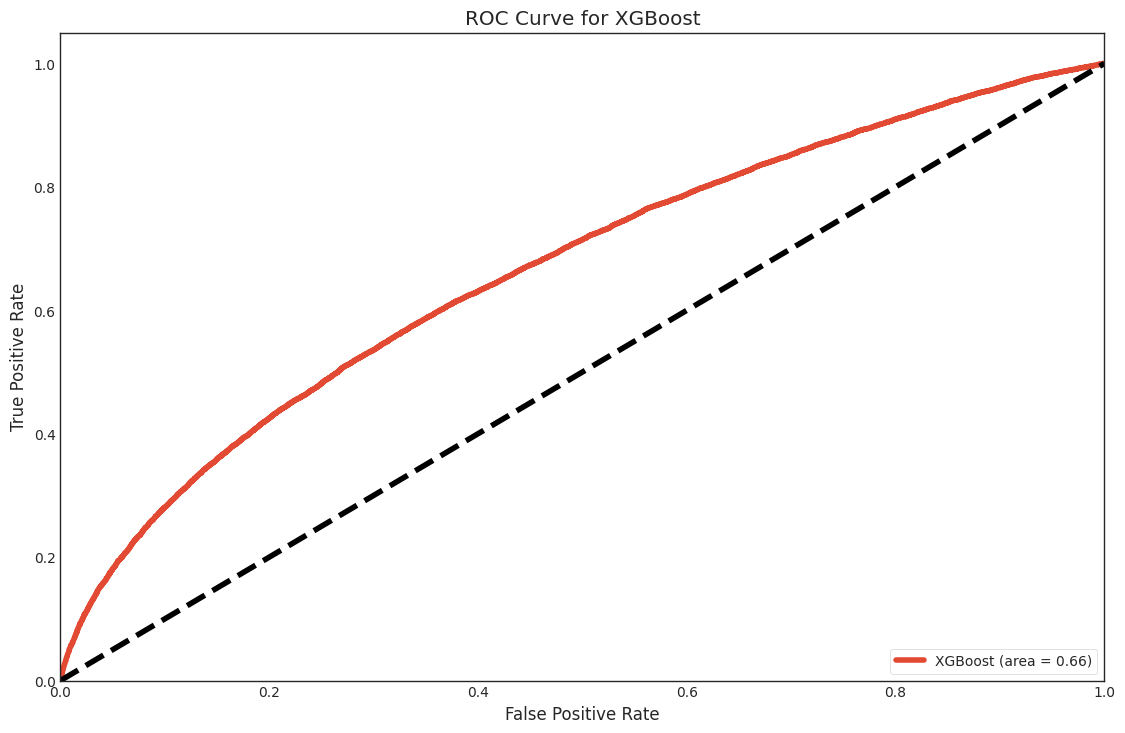

In [32]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


positive_class_weight = 12

# Создание экземпляра модели XGBClassifier с установленным весом положительного класса
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=positive_class_weight)

# Обучение модели
xgb_model.fit(X_train, y_train)


# Предсказания на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)

y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]


print("Классификационный отчет для XGBoost:\n", classification_report(y_test, y_pred_xgb))

print("Confusion Matrix для XGBoost:\n", confusion_matrix(y_test, y_pred_xgb))

roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC AUC для XGBoost:", roc_auc_xgb)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

Модели выдают ROC более 60%, что говорит о перспективности дальнейшей работы с ними.

# <a id="ch007"></a>
## Описание данных, анализ и очистка
* id — идентификатор заявки. Заявки пронумерованы так, что большему
номеру соответствует более поздняя дата заявки.
* rn — порядковый номер кредитного продукта в кредитной истории.
Большему номеру соответствует продукт с более поздней датой открытия.
* pre_since_opened — количество дней с даты открытия кредита до даты
сбора данных (бинаризовано*).
* pre_since_confirmed — количество дней с даты подтверждения
информации по кредиту до даты сбора данных (бинаризовано*).
* pre_pterm — плановое количество дней с даты открытия кредита до даты
закрытия (бинаризовано*).
* pre_fterm — фактическое количество дней с даты открытия кредита до
даты закрытия (бинаризовано*).
* pre_till_pclose	— плановое количество дней с даты сбора данных до даты
"акрытия кредита (бинаризовано*).
* pre_till_fclose	— фактическое количество дней с даты сбора данных до
даты "акрытия кредита (бинаризовано*).
* pre_loans_credit_limit	 — кредитный лимит (бинаризовано*).
* pre_loans_next_pay_summ — сумма следующего платежа по кредиту
(бинаризовано*).
* pre_loans_outstanding — оставшаяся невыплаченная сумма кредита
(бинаризовано*).
* pre_loans_total_oÜerdue — текущая просроченная "адолженность
(бинаризовано*).
* pre_loans_max_oÜerdue_sum — максимальная просроченная
"адолженность (бинаризовано*).
* pre_loans_credit_cost_rate — полная стоимость кредита (бинаризовано*).
* pre_loans5 — число просрочек до 5 дней (бинаризовано*).
* pre_loans530 — число просрочек от 5 до 30 дней (бинаризовано*).
* pre_loans3060 — число просрочек от 30 до 60 дней (бинаризовано*).
* pre_loans6090 — число просрочек от 60 до 90 дней (бинаризовано*).
* pre_loans90 — число просрочек более чем на 90 дней (бинаризовано*).
* is_zero_loans_5 — флаг: нет просрочек до 5 дней.
* is_zero_loans_530 — флаг: нет просрочек от 5 до 30 дней.
* is_zero_loans_3060 — флаг: нет просрочек от 30 до 60 дней.
* is_zero_loans_6090 — флаг: нет просрочек от 60 до 90 дней.
* is_zero_loans90 — флаг: нет просрочек более чем на 90 дней.
* pre_util — отношение оставшейся невыплаченной суммы кредита
к кредитному лимиту (бинаризовано*).
* pre_over2limit	— отношение текущей просроченной "адолженности
к кредитному лимиту (бинаризовано*).
* pre_till_pclose	— плановое количество дней с даты сбора данных до даты
"акрытия кредита (бинаризовано*).
* pre_till_fclose	— фактическое количество дней с даты сбора данных до
даты "акрытия кредита (бинаризовано*).
* pre_loans_credit_limit	 — кредитный лимит (бинаризовано*).
* pre_loans_next_pay_summ — сумма следующего платежа по кредиту
(бинаризовано*).
* pre_loans_outstanding — оставшаяся невыплаченная сумма кредита
(бинаризовано*).
* pre_loans_total_oÜerdue — текущая просроченная "задолженность
(бинаризовано*).
* pre_loans_max_oÜerdue_sum — максимальная просроченная
"адолженность (бинаризовано*).
* pre_loans_credit_cost_rate — полная стоимость кредита (бинаризовано*).
* pre_loans5 — число просрочек до 5 дней (бинаризовано*).
* pre_loans530 — число просрочек от 5 до 30 дней (бинаризовано*).
* pre_loans3060 — число просрочек от 30 до 60 дней (бинаризовано*).
* pre_loans6090 — число просрочек от 60 до 90 дней (бинаризовано*).
* pre_loans90 — число просрочек более чем на 90 дней (бинаризовано*).
* is_zero_loans_5 — флаг: нет просрочек до 5 дней.
* is_zero_loans_530 — флаг: нет просрочек от 5 до 30 дней.
* is_zero_loans_3060 — флаг: нет просрочек от 30 до 60 дней.
* is_zero_loans_6090 — флаг: нет просрочек от 60 до 90 дней.
* is_zero_loans90 — флаг: нет просрочек более чем на 90 дней.
* pre_util — отношение оставшейся невыплаченной суммы кредита
к кредитному лимиту (бинаризовано*).
* pre_over2limit	— отношение текущей просроченной "адолженности
к кредитному лимиту (бинаризовано*).
* pre_maxover2limit — отношение максимальной просроченной
задолженности к кредитному лимиту (бинаризовано*).
* is_zero_util — флаг: отношение оставшейся невыплаченной суммы
кредита к кредитному лимиту равно 0.
* is_zero_over2limit — флаг: отношение текущей просроченной
задолженности к кредитному лимиту равно 0.
* is_zero_maxover2limit — флаг: отношение максимальной просроченной
задолженности к кредитному лимиту равно 0.
* enc_paym_{0..N} — статусы ежемесячных платежей за последние N
месяцев (закодировано**).
* enc_loans_account_holder_type — тип отношения к кредиту
(закодировано**).
* enc_loans_credit_status — статус кредита (закодировано**).
* enc_loans_account_cur — валюта кредита (закодировано**).
* enc_loans_credit_type — тип кредита (закодировано**).
* pclose_flag — флаг: плановое количество дней с даты открытия кредита
до даты закрытия не определено.
* fclose_flag — флаг: фактическое количество дней с даты открытия
кредита до даты закрытия не определено.

*- *Область значений поля разбивается на N непересекающихся промежутков.
Каждому промежутку случайным образом назначается уникальный номер

от 0 до N-1E а значение поля заменяется номером промежуткаE которому оно
принадлежит*

In [33]:
from IPython.display import display, HTML
import pandas as pd

# Создание и добавление HTML-таблицы для статистических характеристик
html_table = "<table>"
for column in merged_data_int8.columns:
    null_count = merged_data_int8[column].isnull().sum()
    if null_count > 0:
        html_table += f"<tr><td><b>{column}</b></td><td>{null_count}</td><td>пропущено</td></tr>"
    else:
        html_table += f"<tr><td><b>{column}</b></td><td>0</td><td>не имеет пропусков</td></tr>"
html_table += "</table>"

html_table += merged_data_int8.describe(include='all').to_html()

display(HTML(html_table))


In [34]:
from IPython.display import display, HTML
import pandas as pd

# Создание DataFrame с типами данных и преобразование DataFrame в HTML
data_types_df = pd.DataFrame({'Столбец': merged_data_int8.columns, 'Тип данных': merged_data_int8.dtypes})

html_table = data_types_df.to_html(index=False)

display(HTML(html_table))


In [35]:
from IPython.display import display, HTML
import pandas as pd

# Создание HTML-таблицы для статистических характеристик и разбивка столбцов по 4 в ряд
html_table = "<table style='width:100%'>"

columns_per_row = 5
columns_count = len(merged_data_int8.columns)
for i in range(0, columns_count, columns_per_row):
    html_table += "<tr>"
    for column in merged_data_int8.columns[i:i+columns_per_row]:
        column_description = merged_data_int8[column].describe(include='all').to_frame().to_html()
        html_table += f"<td style='vertical-align: top; width: {100/columns_per_row}%;'>"
        html_table += f"{column_description}"
        html_table += "</td>"
    html_table += "</tr>"

html_table += "</table>"

display(HTML(html_table))



Наш датафрейм не содержит пропусков, выбросов, аномалий. Имеются 2 вида признаков: бинаризованные и закодированные. Поработаем с ними.

In [36]:
# Бинаризованные признаки:
binary_columns = [col for col in merged_data_int8.columns if merged_data_int8[col].nunique() == 2]
# Удаляем столбец 'flag' из списка binary_columns
binary_columns.remove('flag')
binary_columns

['is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_over2limit',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag']

In [37]:
# Создаем список столбцов, которые нужно исключить
columns_to_exclude = ['flag', 'id', 'rn'] + binary_columns

# Получаем список столбцов, которые остаются после исключения
categorical_features = merged_data_int8.columns.difference(columns_to_exclude).tolist()
len(categorical_features)

49

In [38]:
categorical_features[5]

'enc_paym_1'

In [39]:
merged_data_int8.dtypes

id                       int64
rn                        int8
pre_since_opened          int8
pre_since_confirmed       int8
pre_pterm                 int8
                         ...  
enc_loans_credit_type     int8
enc_loans_account_cur     int8
pclose_flag               int8
fclose_flag               int8
flag                      int8
Length: 62, dtype: object

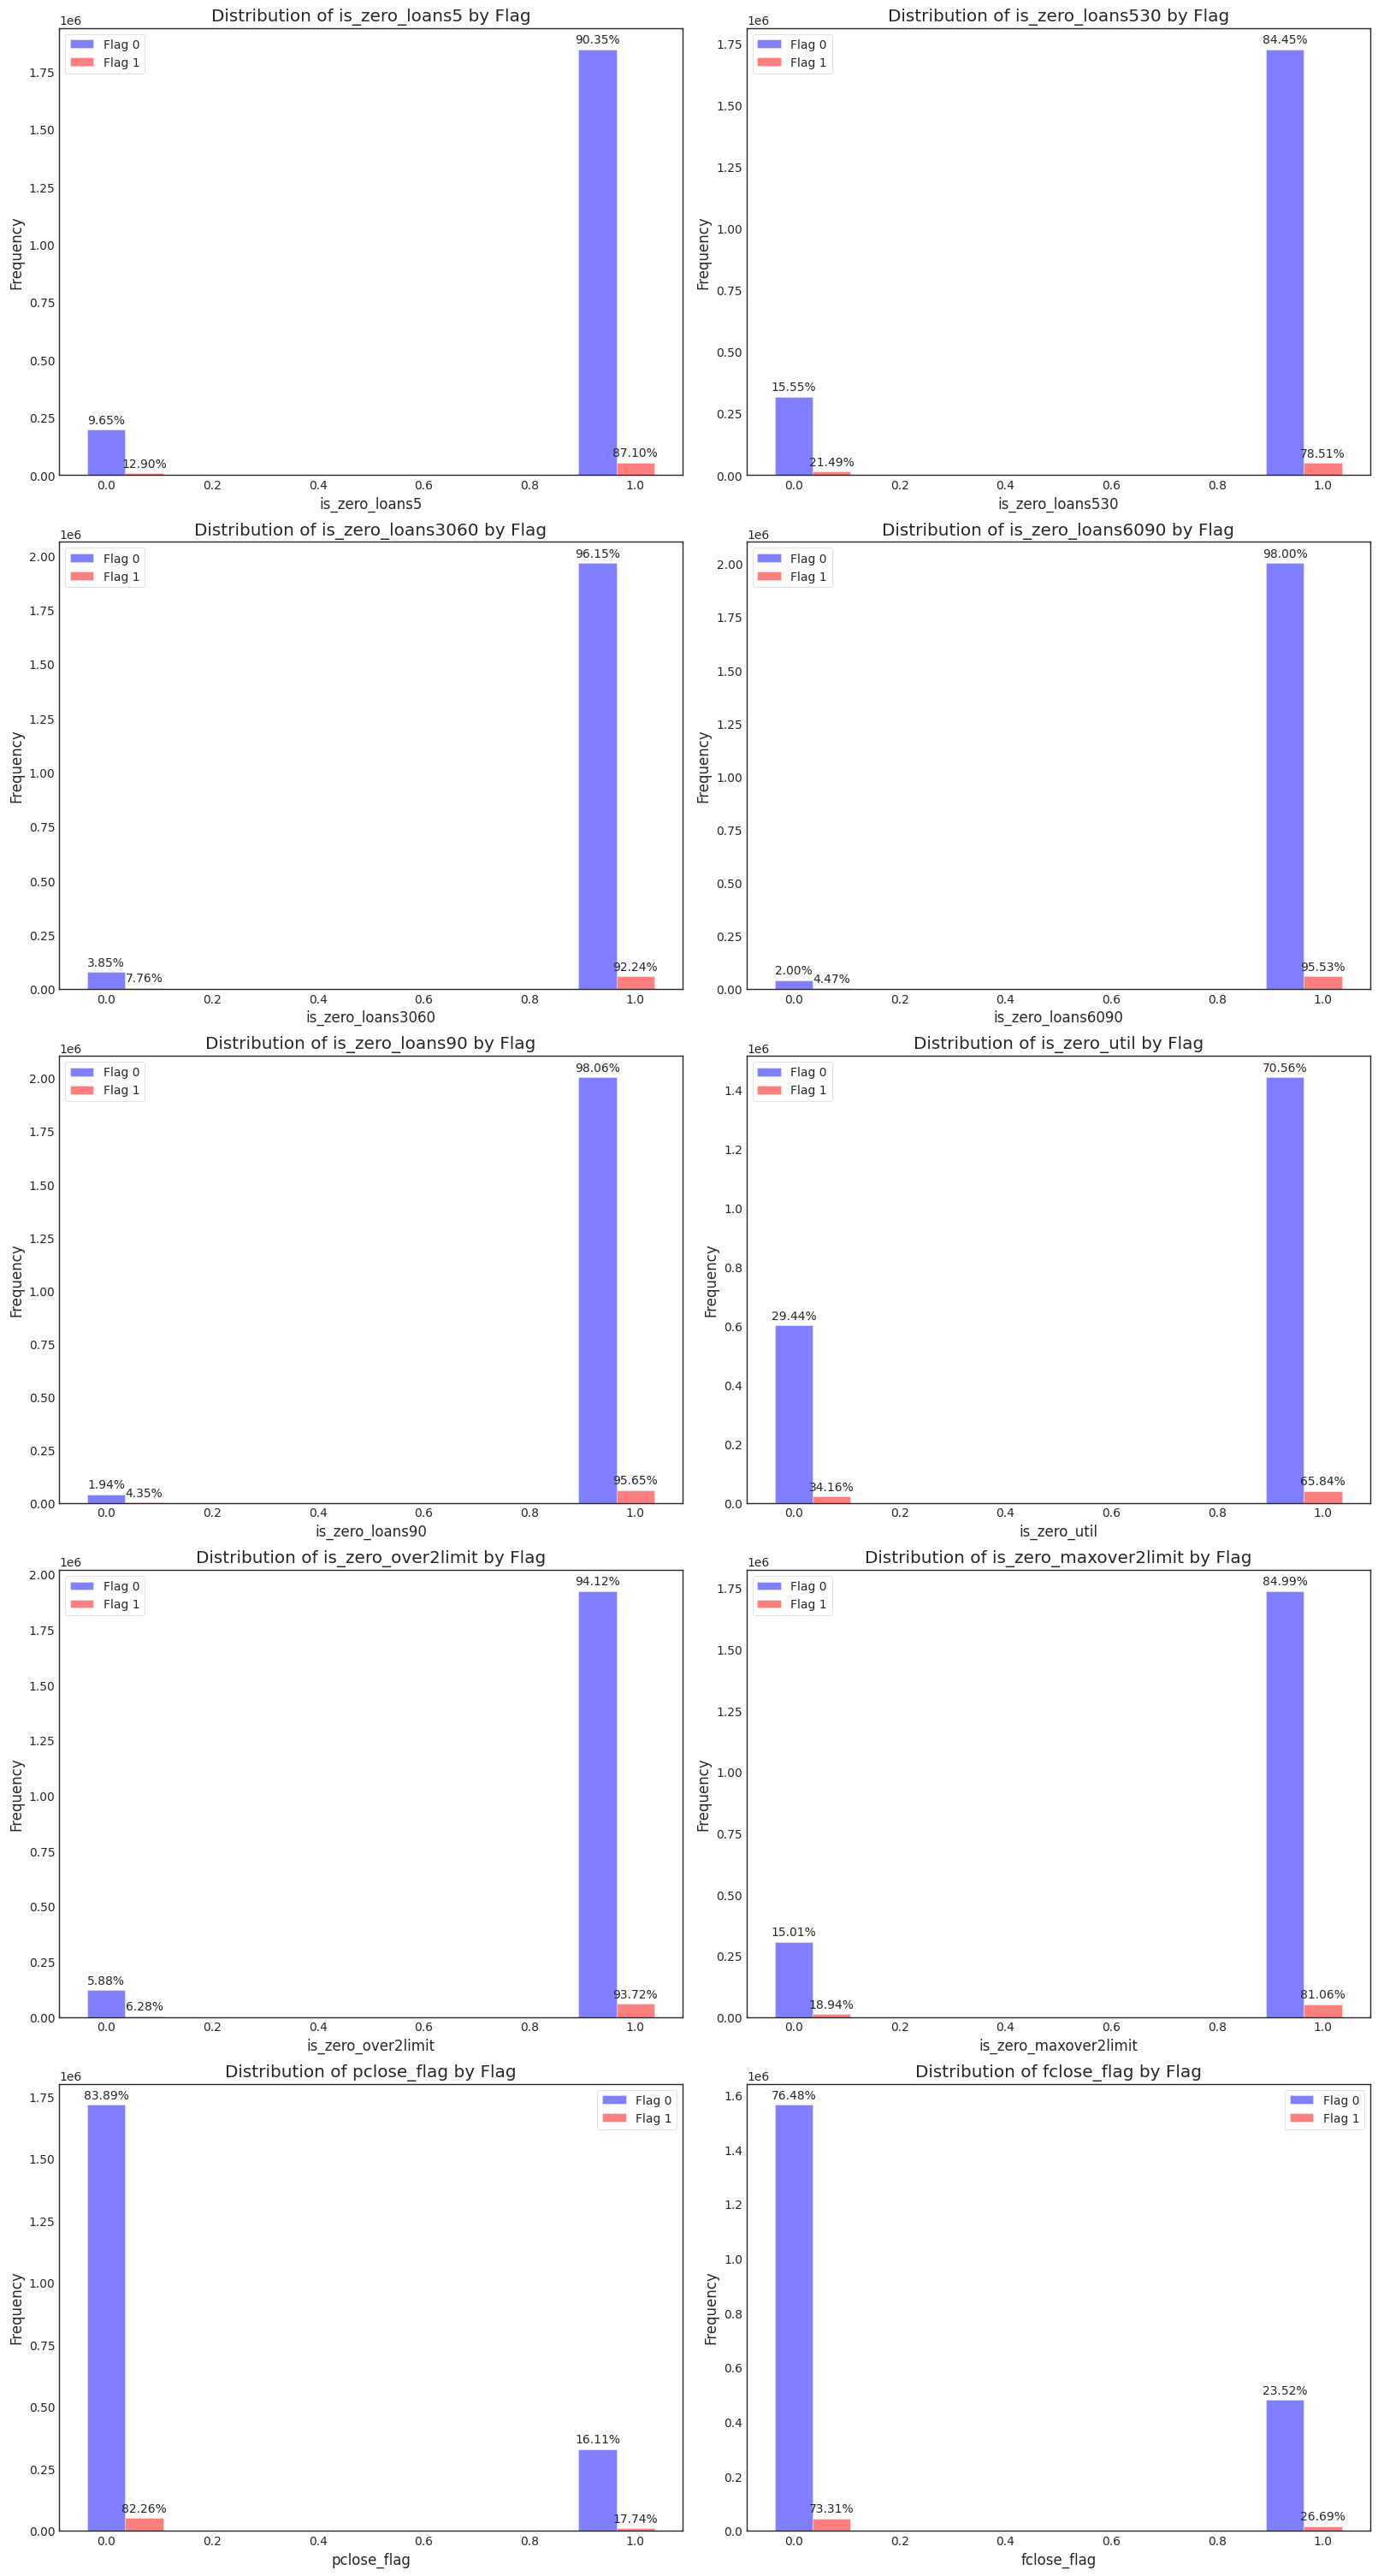

In [40]:
plot_categorical_distributions(merged_data_int8, binary_columns, flag_column='flag', cols=2)


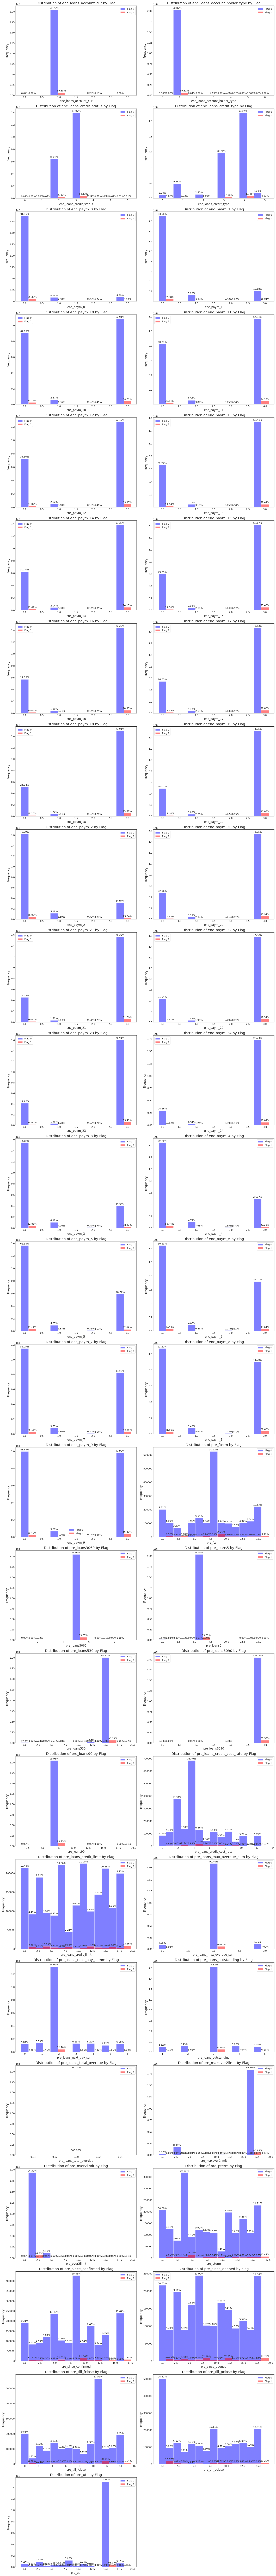

In [41]:
plot_categorical_distributions(merged_data_int8, categorical_features, flag_column='flag', cols=2)


Исследования показали, что пропущенных данных в датафрейме нет, выбросы, аномалии - отсутствуют.

Проведем анализ корреляции.

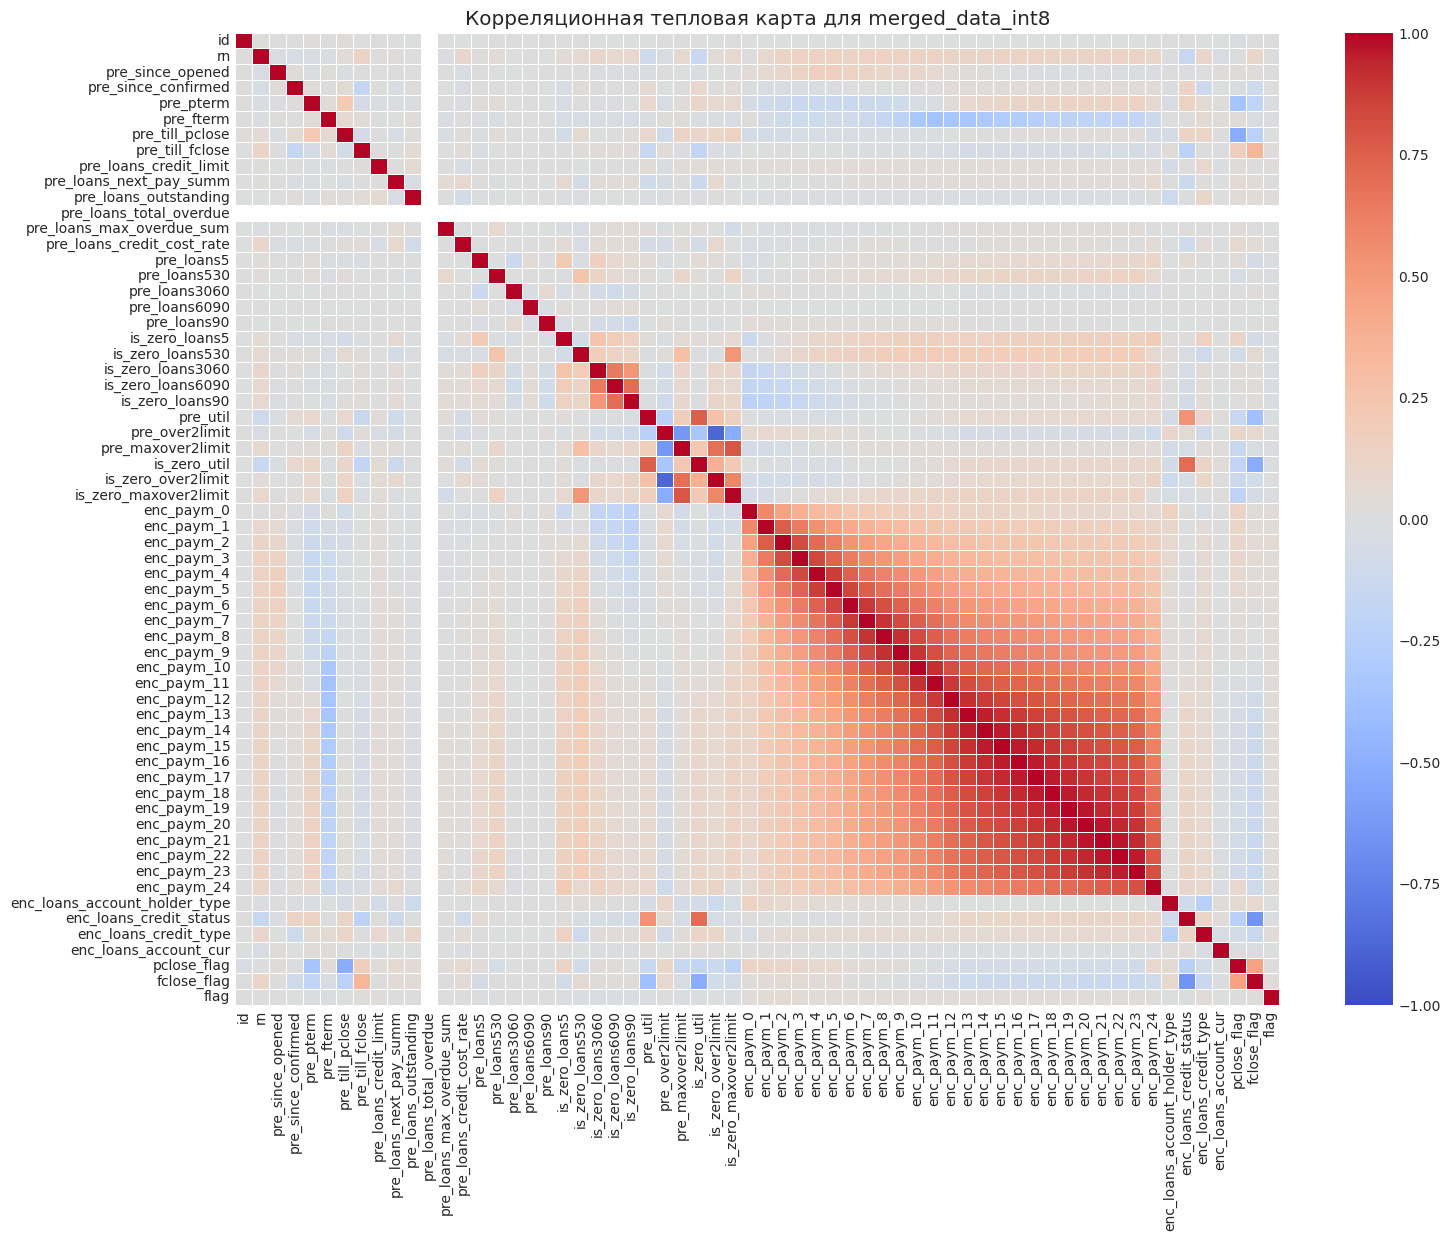

In [42]:
correlation_matrix = merged_data_int8.corr()

# Построение тепловой карты
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Корреляционная тепловая карта для merged_data_int8')
plt.show()

Обнаружен признак с пропусками `pre_loans_total_overdue`. Удалим его.

In [43]:
# Преобразование корреляционной матрицы в длинный формат
corr_long = correlation_matrix.unstack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Исключение самокорреляций
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]

# Удаление дубликатов
corr_long = corr_long.drop_duplicates(subset=['Correlation'])

# Округление корреляций до двух десятичных знаков
corr_long['Correlation'] = corr_long['Correlation'].round(2)

# Сортировка по абсолютному значению корреляции
sorted_corr = corr_long.reindex(corr_long['Correlation'].abs().sort_values(ascending=False).index)

# Печать корреляций в порядке убывания по модулю
print("Корреляции в порядке убывания по модулю:")
print(sorted_corr)

Корреляции в порядке убывания по модулю:
         Feature1                 Feature2  Correlation
3025  enc_paym_18              enc_paym_19         0.96
3151  enc_paym_20              enc_paym_21         0.96
3214  enc_paym_21              enc_paym_22         0.96
3088  enc_paym_19              enc_paym_20         0.96
3277  enc_paym_22              enc_paym_23         0.96
...           ...                      ...          ...
10             id    pre_loans_outstanding        -0.00
9              id  pre_loans_next_pay_summ        -0.00
8              id   pre_loans_credit_limit         0.00
7              id          pre_till_fclose        -0.00
11             id  pre_loans_total_overdue          NaN

[1831 rows x 3 columns]


Таблица корелляции со значениями > 0.85

Корреляции больше 0.85 по модулю:
            Feature1            Feature2  Correlation
1578  pre_over2limit  is_zero_over2limit        -0.88
2143      enc_paym_4          enc_paym_5         0.87
2269      enc_paym_6          enc_paym_7         0.89
2332      enc_paym_7          enc_paym_8         0.90
2395      enc_paym_8          enc_paym_9         0.91
2458      enc_paym_9         enc_paym_10         0.89
2521     enc_paym_10         enc_paym_11         0.91
2584     enc_paym_11         enc_paym_12         0.89
2647     enc_paym_12         enc_paym_13         0.92
2648     enc_paym_12         enc_paym_14         0.88
2710     enc_paym_13         enc_paym_14         0.95
2711     enc_paym_13         enc_paym_15         0.91
2712     enc_paym_13         enc_paym_16         0.88
2773     enc_paym_14         enc_paym_15         0.96
2774     enc_paym_14         enc_paym_16         0.92
2775     enc_paym_14         enc_paym_17         0.89
2776     enc_paym_14         enc_paym_18        

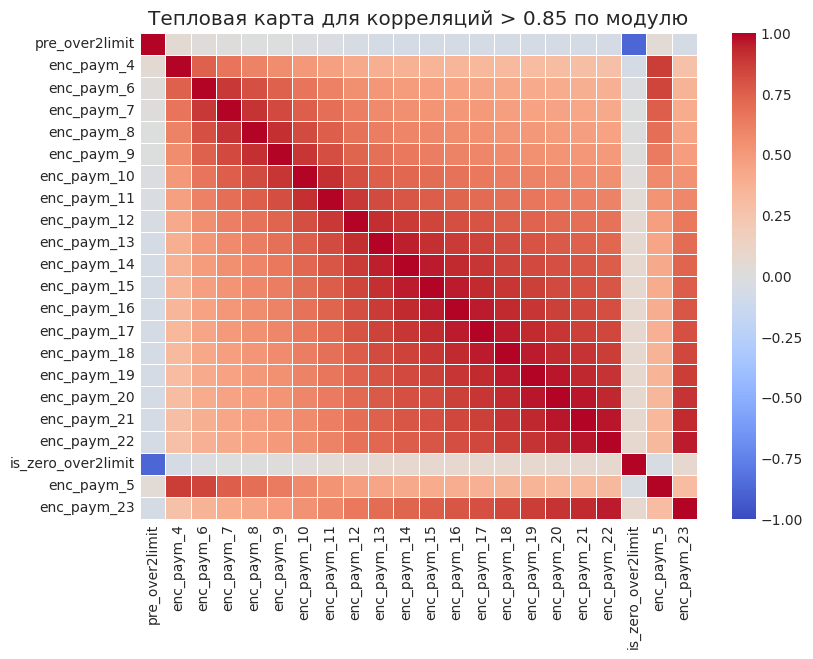

In [44]:
# Преобразование корреляционной матрицы в длинный формат
corr_long = correlation_matrix.unstack().reset_index()
corr_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Исключение самокорреляций
corr_long = corr_long[corr_long['Feature1'] != corr_long['Feature2']]

# Удаление дубликатов
corr_long = corr_long.drop_duplicates(subset=['Correlation'])

# Округление корреляций до двух десятичных знаков
corr_long['Correlation'] = corr_long['Correlation'].round(2)

# Фильтрация корреляций по условию |Correlation| > 0.85
high_corr = corr_long[corr_long['Correlation'].abs() > 0.85]

# Печать корреляций больше 0.85 по модулю
print("Корреляции больше 0.85 по модулю:")
print(high_corr)

# Извлечение уникальных признаков
high_corr_features = pd.unique(high_corr[['Feature1', 'Feature2']].values.ravel('K'))

# Создание новой корреляционной матрицы для этих признаков
high_corr_matrix = merged_data_int8[high_corr_features].corr()

# Построение тепловой карты для высоких корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(high_corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Тепловая карта для корреляций > 0.85 по модулю')
plt.show()

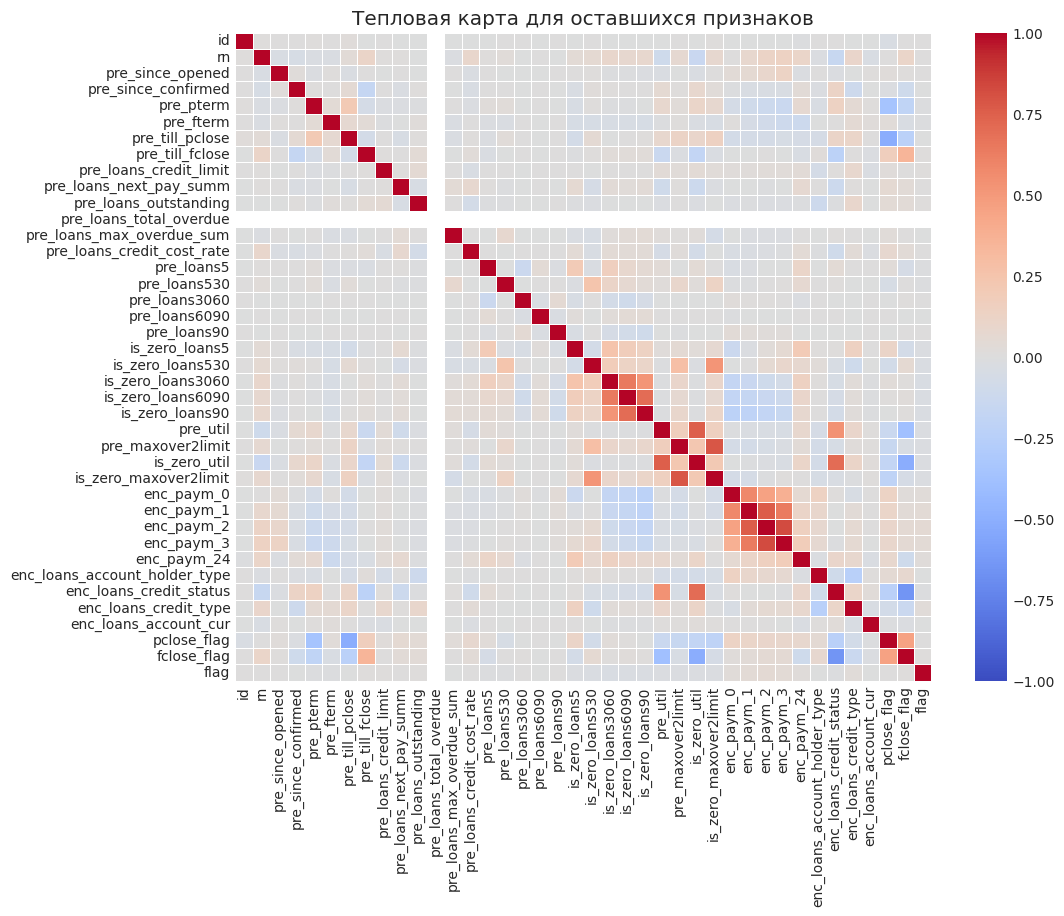

In [45]:
# Извлечение уникальных признаков
high_corr_features = pd.unique(high_corr[['Feature1', 'Feature2']].values.ravel('K'))

# Удаление признаков с высокой корреляцией
reduced_data = merged_data_int8.drop(columns=high_corr_features)
# Построение тепловой карты для оставшихся признаков
correlation_matrix_reduced = reduced_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_reduced, annot= False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Тепловая карта для оставшихся признаков')
plt.show()

Удалим признаки

In [46]:
reduced_data = reduced_data.drop('pre_loans_total_overdue', axis=1)

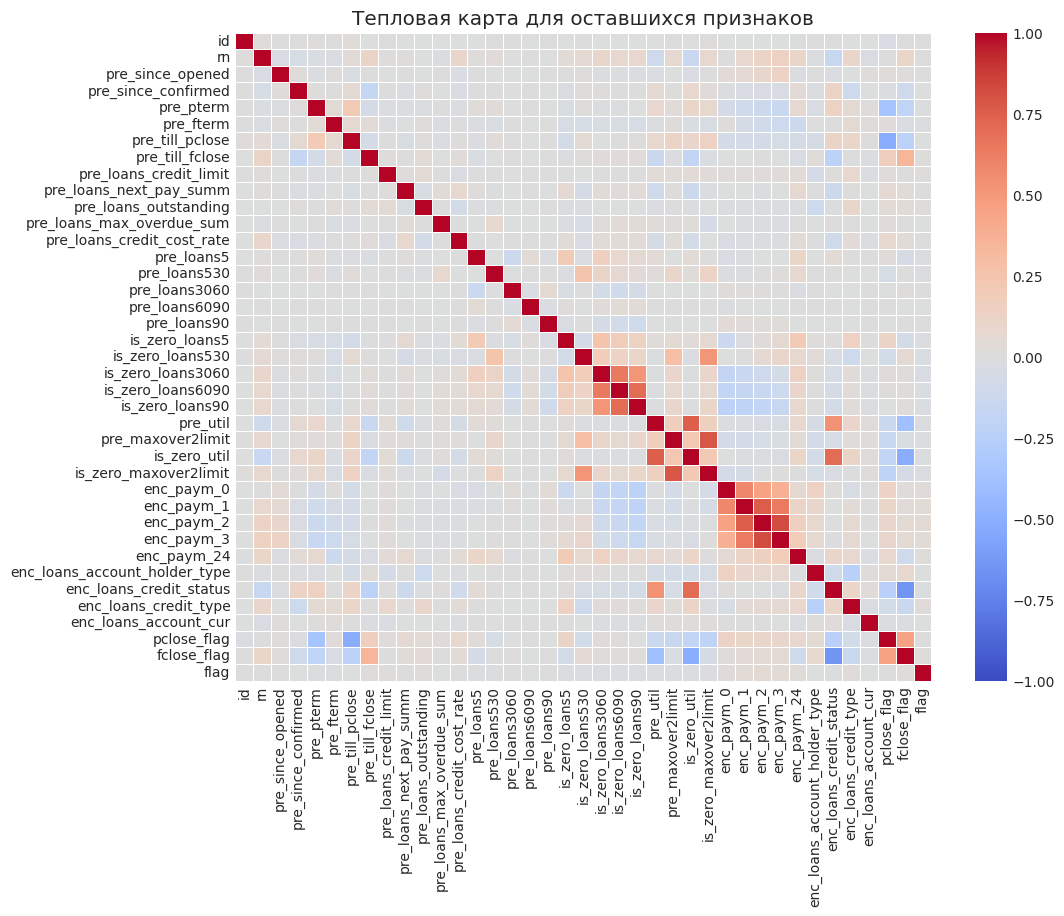

In [47]:
# Построение тепловой карты для оставшихся признаков
correlation_matrix_reduced = reduced_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_reduced, annot= False, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Тепловая карта для оставшихся признаков')
plt.show()

In [48]:
len(reduced_data.columns)

39

Сформируем списки признаков для удобства в `reduced_data`

In [49]:
# Бинаризованные признаки:

binary_columns = [col for col in reduced_data.columns if reduced_data[col].nunique() == 2]
# Удаляем столбец 'flag' из списка binary_columns
binary_columns.remove('flag')
binary_columns

['is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans3060',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_util',
 'is_zero_maxover2limit',
 'pclose_flag',
 'fclose_flag']

In [50]:
# Создаем список столбцов, которые нужно исключить
columns_to_exclude = ['flag', 'id', 'rn'] + binary_columns

# Получаем список столбцов, которые остаются после исключения
categorical_features = reduced_data.columns.difference(columns_to_exclude).tolist()
len(categorical_features)

27

In [51]:
# Применение one-hot encoding к категориальным признакам и удаление исходных столбцов
merged_data_int8_encoded = pd.get_dummies(merged_data_int8, columns=categorical_features, drop_first=True)

# Печать результирующего DataFrame
print("Результирующий DataFrame после one-hot encoding и удаления исходных категориальных столбцов:")
merged_data_int8_encoded

Результирующий DataFrame после one-hot encoding и удаления исходных категориальных столбцов:


id  rn  pre_loans_total_overdue  is_zero_loans5  \
0        250000   1                        0               1   
1        250000   2                        0               1   
2        250000   3                        0               1   
3        250000   4                        0               1   
4        250000   5                        0               1   
...         ...  ..                      ...             ...   
2107300  499999   8                        0               1   
2107301  499999   9                        0               1   
2107302  499999  10                        0               1   
2107303  499999  11                        0               1   
2107304  499999  12                        0               1   

         is_zero_loans530  is_zero_loans3060  is_zero_loans6090  \
0                       0                  1                  0   
1                       1                  0                  0   
2                       0                  0                  1   
3                       0                  0                  0   
4                       1                  1                  1   
...                   ...                ...                ...   
2107300                 1                  1                  1   
2107301                 1                  1                  1   
2107302                 1                  1                  1   
2107303                 1                  1                  1   
2107304                 1                  1                  1   

         is_zero_loans90  pre_over2limit  is_zero_util  ...  pre_util_10  \
0                      0               2             1  ...        False   
1                      1               2             1  ...        False   
2                      1               2             1  ...        False   
3                      0               2             1  ...        False   
4                      0               5             0  ...        False   
...                  ...             ...           ...  ...          ...   
2107300                1               2             1  ...        False   
2107301                1               2             1  ...        False   
2107302                1               2             0  ...        False   
2107303                1               2             0  ...        False   
2107304                1               2             0  ...        False   

         pre_util_11  pre_util_12  pre_util_13  pre_util_14  pre_util_15  \
0              False        False        False        False        False   
1              False        False        False        False        False   
2              False        False        False        False        False   
3              False        False        False        False        False   
4              False        False        False        False        False   
...              ...          ...          ...          ...          ...   
2107300        False        False        False        False        False   
2107301        False        False        False        False        False   
2107302        False        False         True        False        False   
2107303        False        False        False        False        False   
2107304        False        False        False        False        False   

         pre_util_16  pre_util_17  pre_util_18  pre_util_19  
0               True        False        False        False  
1               True        False        False        False  
2               True        False        False        False  
3               True        False        False        False  
4              False        False        False        False  
...              ...          ...          ...          ...  
2107300         True        False        False        False  
2107301         True        False        False        False  
2107302        False        False        False        F

<a id="ch009"></a>
## Группировка датафрейма по id и моделирование

In [52]:
df_mean = merged_data_int8_encoded.groupby('id').mean().reset_index()

In [53]:
# Удаление столбцов 'id' и 'rn'
df = df_mean.drop(['id', 'rn'], axis=1)

# Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     48371
         1.0       0.08      0.67      0.14      1629

    accuracy                           0.73     50000
   macro avg       0.53      0.70      0.49     50000
weighted avg       0.96      0.73      0.82     50000

Confusion Matrix:
 [[35297 13074]
 [  542  1087]]
ROC AUC: 0.7615157827279813


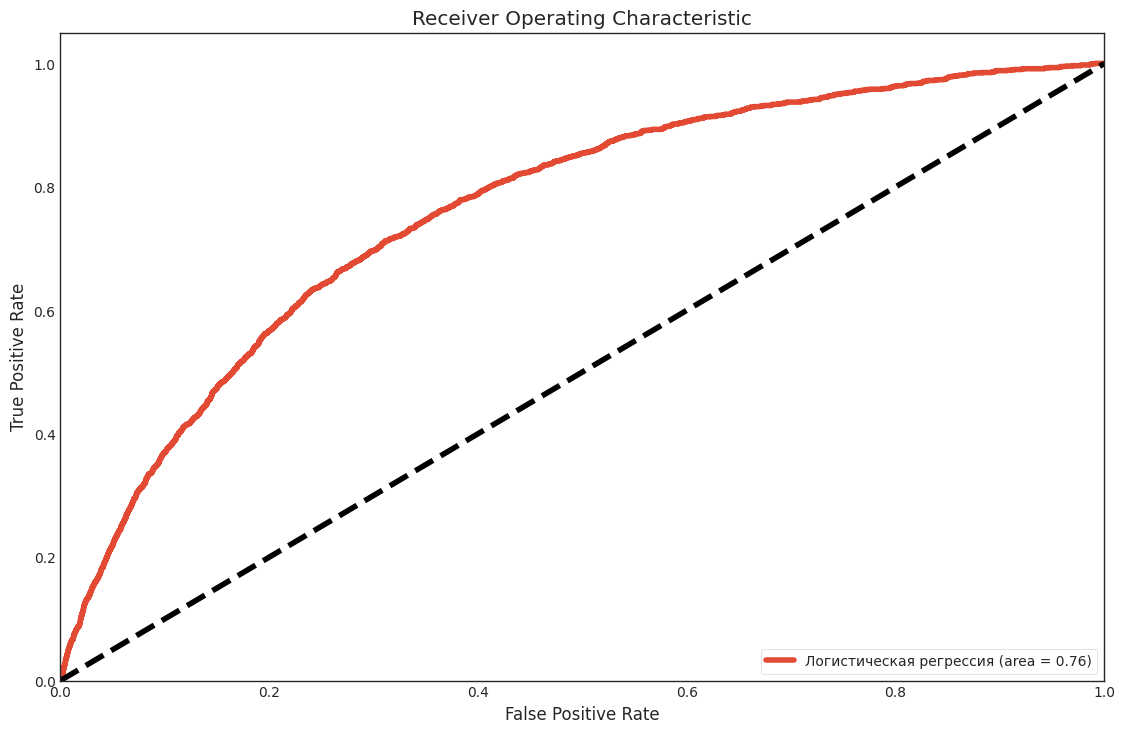

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Классификационный отчет:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC AUC:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая регрессия (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Cross-validation ROC AUC scores: [0.73947342 0.72851519 0.73546822 0.72056833 0.72929685]
Mean ROC AUC score: 0.7306644027829416
Классификационный отчет для XGBoost на тестовом наборе:
               precision    recall  f1-score   support

         0.0       0.98      0.90      0.94     48371
         1.0       0.10      0.32      0.15      1629

    accuracy                           0.88     50000
   macro avg       0.54      0.61      0.55     50000
weighted avg       0.95      0.88      0.91     50000

Confusion Matrix для XGBoost на тестовом наборе:
 [[43711  4660]
 [ 1111   518]]
ROC AUC для XGBoost на тестовом наборе: 0.7328453590095451


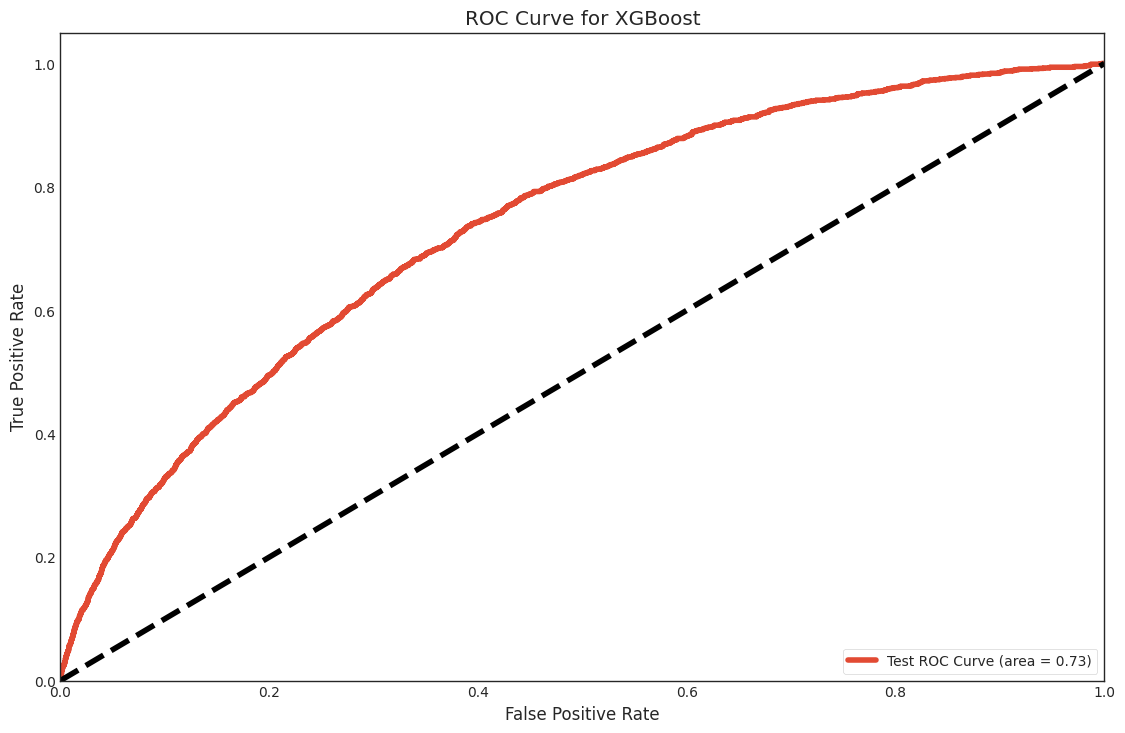

In [55]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Создание экземпляра модели XGBClassifier с установленным весом положительного класса
positive_class_weight = 18
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=positive_class_weight)

# Кросс-валидация
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(xgb_model, X, y, cv=kfold, scoring='roc_auc')

print("Cross-validation ROC AUC scores:", results)
print("Mean ROC AUC score:", results.mean())

# Обучение модели на всем наборе данных
xgb_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("Классификационный отчет для XGBoost на тестовом наборе:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix для XGBoost на тестовом наборе:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC AUC для XGBoost на тестовом наборе:", roc_auc_xgb)

# Построение ROC-кривой
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'Test ROC Curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()


Модель логистической регрессии определяет ROC > 76%, что удовлетворяет требованиям задачи.


<a id="ch0010"></a>
## Feature-инжиниринг

Примеры новых признаков:
1. Сумма просрочек: Сумма всех видов просрочек.
2. Среднее значение дней с момента открытия до даты сбора данных: Среднее значение из pre_since_opened и pre_since_confirmed.
3. Флаги просрочек: Сумма флагов просрочек.
4. Максимальное и минимальное значение суммы следующего платежа: Из признаков pre_loans_next_pay_summ.
5. Разница между фактическими и плановыми сроками закрытия кредита: pre_till_fclose - pre_till_pclose.

In [56]:
import pandas as pd

# Инициализация DataFrame с идентификатором из merged_data_int8
new_features = merged_data_int8[['id']].copy()

# Добавление новых столбцов с вычислениями
new_features['total_overdue'] = (merged_data_int8['pre_loans5'] +
                                  merged_data_int8['pre_loans530'] +
                                  merged_data_int8['pre_loans3060'] +
                                  merged_data_int8['pre_loans6090'] +
                                  merged_data_int8['pre_loans90'])

new_features['avg_days_since_open'] = (merged_data_int8['pre_since_opened'] +
                                        merged_data_int8['pre_since_confirmed']) / 2

new_features['total_zero_loans'] = (merged_data_int8['is_zero_loans5'] +
                                     merged_data_int8['is_zero_loans530'] +
                                     merged_data_int8['is_zero_loans3060'] +
                                     merged_data_int8['is_zero_loans6090'] +
                                     merged_data_int8['is_zero_loans90'])

# Использование агрегации для получения max и min
new_features['max_next_pay_summ'] = merged_data_int8['pre_loans_next_pay_summ'].max()
new_features['min_next_pay_summ'] = merged_data_int8['pre_loans_next_pay_summ'].min()

new_features['diff_till_close'] = merged_data_int8['pre_till_fclose'] - merged_data_int8['pre_till_pclose']

# Избегаем деления на ноль
new_features['outstanding_to_credit_limit'] = merged_data_int8['pre_loans_outstanding'] / (merged_data_int8['pre_loans_credit_limit'] + 1e-10)
new_features['overdue_to_credit_limit'] = merged_data_int8['pre_loans_total_overdue'] / (merged_data_int8['pre_loans_credit_limit'] + 1e-10)
new_features['max_overdue_to_credit_limit'] = merged_data_int8['pre_loans_max_overdue_sum'] / (merged_data_int8['pre_loans_credit_limit'] + 1e-10)

# Определение N
N = sum(1 for col in merged_data_int8.columns if col.startswith('enc_paym_'))

# Создание бинарных признаков
for i in range(N):
    column_name = f'enc_paym_{i}'
    if column_name in merged_data_int8.columns:
        new_features[f'{column_name}_flag'] = (merged_data_int8[column_name] > 0).astype(int)

# Вывод первых нескольких строк для проверки
print(new_features.head())

       id  total_overdue  avg_days_since_open  total_zero_loans  \
0  250000             39                  7.5                 2   
1  250000             39                 11.0                 3   
2  250000             39                  7.0                 3   
3  250000             39                 12.5                 1   
4  250000             39                  9.0                 4   

   max_next_pay_summ  min_next_pay_summ  diff_till_close  \
0                  6                  0                5   
1                  6                  0               -3   
2                  6                  0                7   
3                  6                  0               -8   
4                  6                  0                6   

   outstanding_to_credit_limit  overdue_to_credit_limit  \
0                         0.60                      0.0   
1                         0.25                      0.0   
2                         0.60                      0.0   


In [57]:
new_features = new_features.drop(['overdue_to_credit_limit', 'enc_paym_11_flag', 'enc_paym_20_flag'], axis=1)


In [58]:
df_mean_new_features = new_features.groupby('id').mean().reset_index()


In [59]:
reduced_data_ = reduced_data.groupby('id').mean().reset_index()

In [60]:
merged_df = df_mean_new_features.merge(reduced_data_, on='id', how='inner')


In [61]:
merged_df.shape

(250000, 70)

In [62]:
# Удаление столбцов 'id' и 'rn'
df = merged_df.drop(['id', 'rn'], axis=1)

# Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Weighted Gradient Boosting - Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     48371
         1.0       0.07      0.61      0.13      1629

    accuracy                           0.73     50000
   macro avg       0.53      0.67      0.48     50000
weighted avg       0.95      0.73      0.82     50000

Weighted Gradient Boosting - Confusion Matrix:
 [[35405 12966]
 [  634   995]]
Weighted Gradient Boosting - ROC AUC: 0.7314619004159824


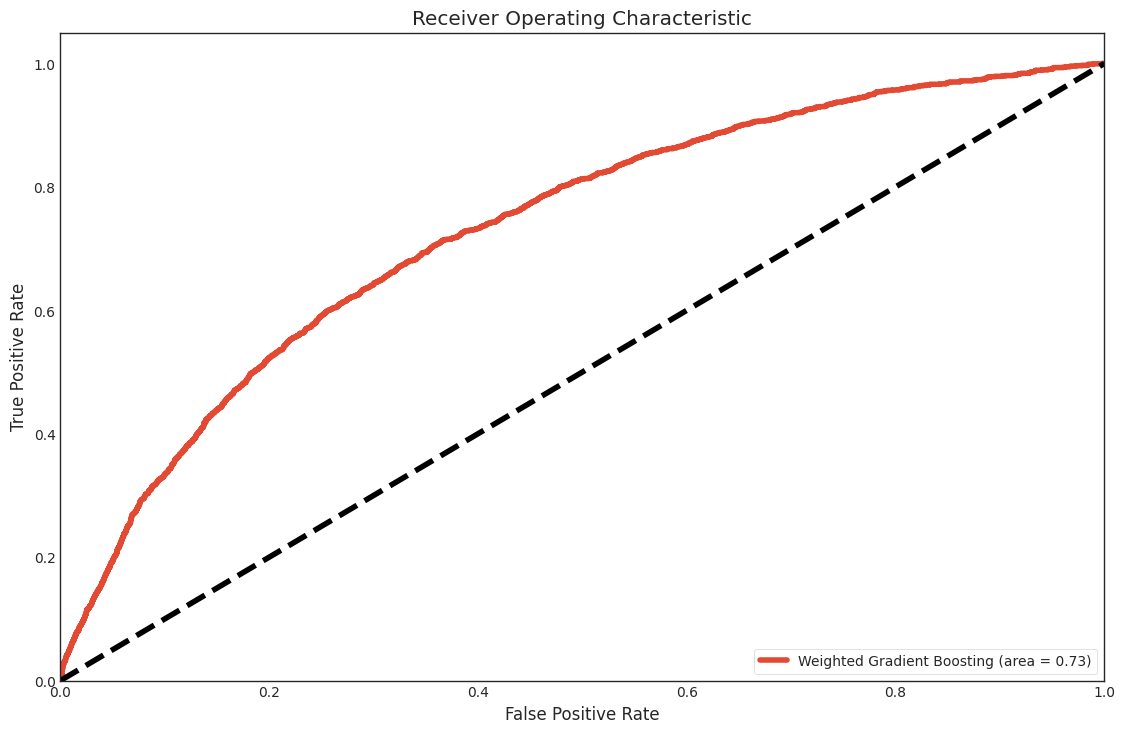

In [63]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
weight = 28
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация параметров модели
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'scale_pos_weight': weight # установка веса класса
}

# Преобразование данных в формат DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Обучение модели
bst = xgb.train(params, dtrain, num_boost_round=100)

# Предсказание на тестовых данных
y_pred_xgb = bst.predict(dtest)

# Преобразование вероятностей в бинарные предсказания
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]

# Расчёт метрик качества
print("Weighted Gradient Boosting - Классификационный отчет:\n", classification_report(y_test, y_pred_binary))
print("Weighted Gradient Boosting - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("Weighted Gradient Boosting - ROC AUC:", roc_auc_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='Weighted Gradient Boosting (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


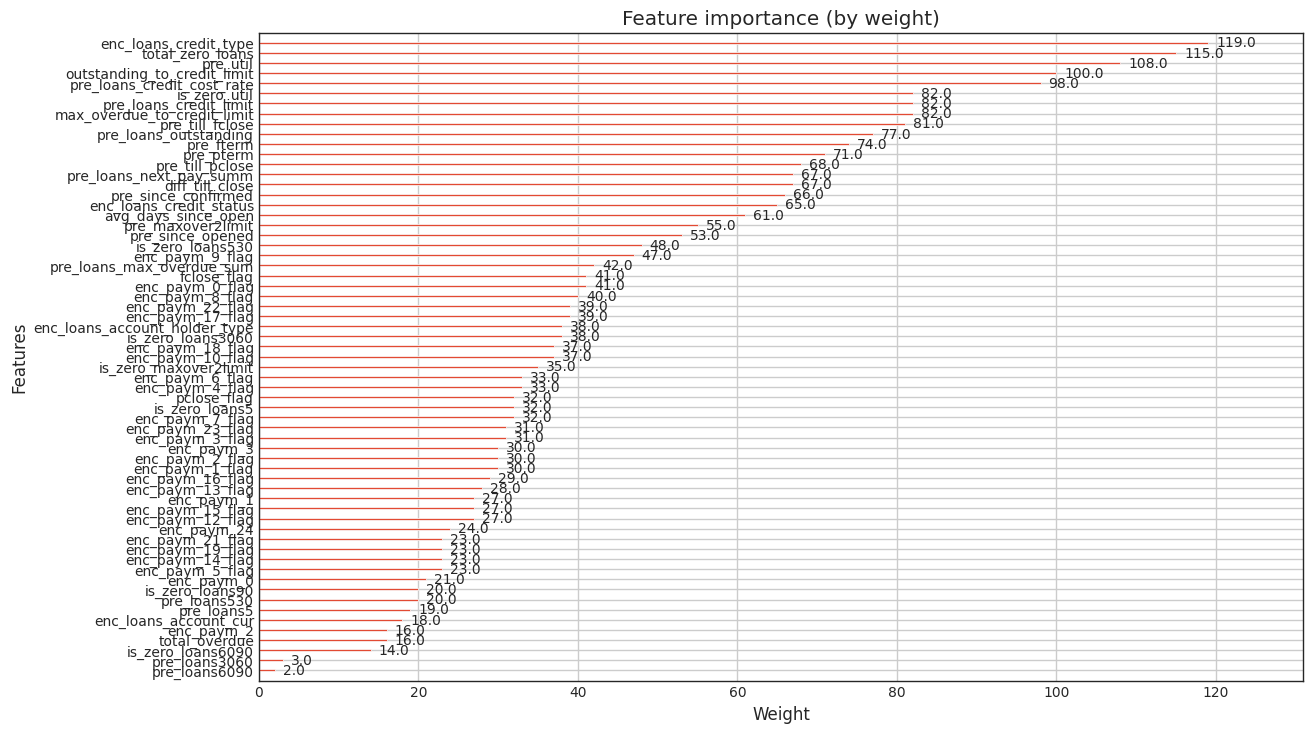

In [64]:
# Построение графика значимости признаков
xgb.plot_importance(bst, importance_type='weight', title='Feature importance (by weight)', xlabel='Weight', ylabel='Features')
plt.show()

In [65]:
importances = bst.get_score(importance_type='weight')
# Отфильтруем признаки с значимостью больше 30
filtered_features = [feature for feature, importance in importances.items() if importance > 5]

# Сократим X_train и X_test до отфильтрованных признаков
X_train_filtered = X_train[filtered_features]
X_test_filtered = X_test[filtered_features]


Filtered Weighted Gradient Boosting - Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.73      0.84     48371
         1.0       0.07      0.61      0.13      1629

    accuracy                           0.73     50000
   macro avg       0.53      0.67      0.48     50000
weighted avg       0.95      0.73      0.82     50000

Filtered Weighted Gradient Boosting - Confusion Matrix:
 [[35356 13015]
 [  634   995]]
Filtered Weighted Gradient Boosting - ROC AUC: 0.7323325751637838


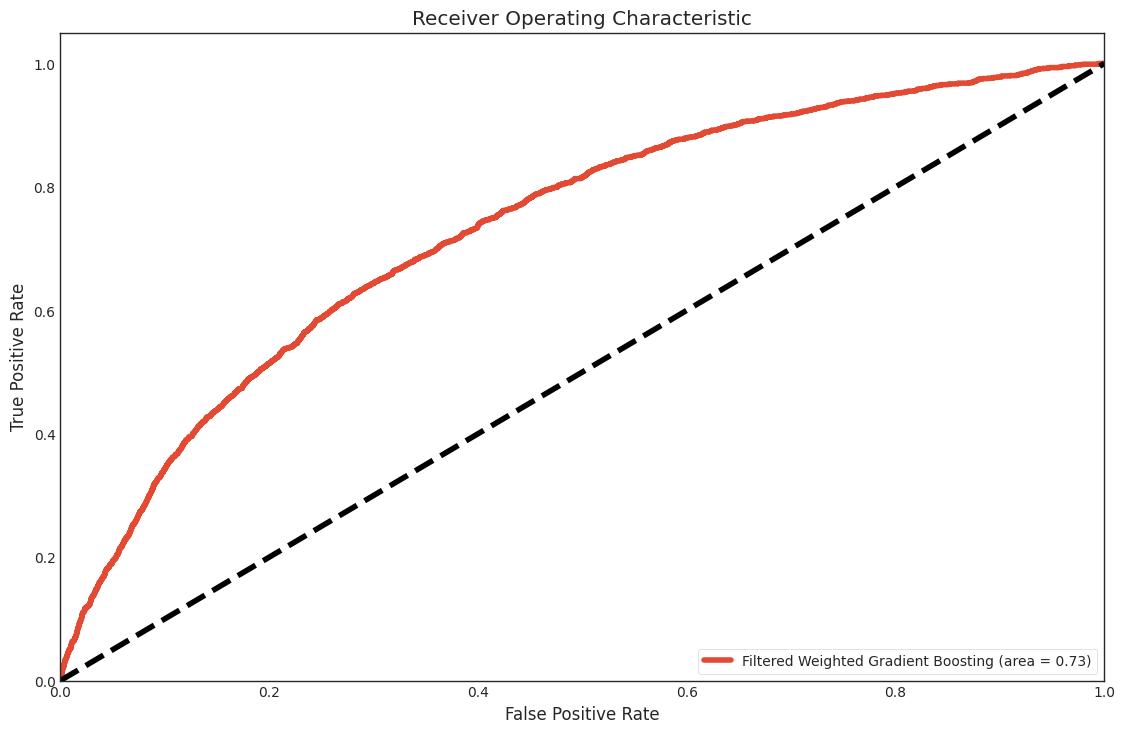

In [66]:
# Преобразование данных в формат DMatrix для XGBoost
dtrain_filtered = xgb.DMatrix(X_train_filtered, label=y_train)
dtest_filtered = xgb.DMatrix(X_test_filtered, label=y_test)

# Обучение модели
bst_filtered = xgb.train(params, dtrain_filtered, num_boost_round=100)

# Предсказание на тестовых данных
y_pred_filtered = bst_filtered.predict(dtest_filtered)

# Преобразование вероятностей в бинарные предсказания
y_pred_binary_filtered = [1 if p >= 0.5 else 0 for p in y_pred_filtered]

# Расчёт метрик качества
print("Filtered Weighted Gradient Boosting - Классификационный отчет:\n", classification_report(y_test, y_pred_binary_filtered))
print("Filtered Weighted Gradient Boosting - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary_filtered))

# ROC AUC
roc_auc_filtered = roc_auc_score(y_test, y_pred_filtered)
print("Filtered Weighted Gradient Boosting - ROC AUC:", roc_auc_filtered)

# ROC Curve
fpr_filtered, tpr_filtered, thresholds_filtered = roc_curve(y_test, y_pred_filtered)
plt.figure()
plt.plot(fpr_filtered, tpr_filtered, label='Filtered Weighted Gradient Boosting (area = %0.2f)' % roc_auc_filtered)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [67]:
# Удаление столбцов 'id' и 'rn'
df = df_mean.drop(['id', 'rn'], axis=1)

# Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Weighted Gradient Boosting - Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.75      0.85     48371
         1.0       0.08      0.63      0.14      1629

    accuracy                           0.75     50000
   macro avg       0.53      0.69      0.50     50000
weighted avg       0.95      0.75      0.83     50000

Weighted Gradient Boosting - Confusion Matrix:
 [[36388 11983]
 [  595  1034]]
Weighted Gradient Boosting - ROC AUC: 0.7603028079000453


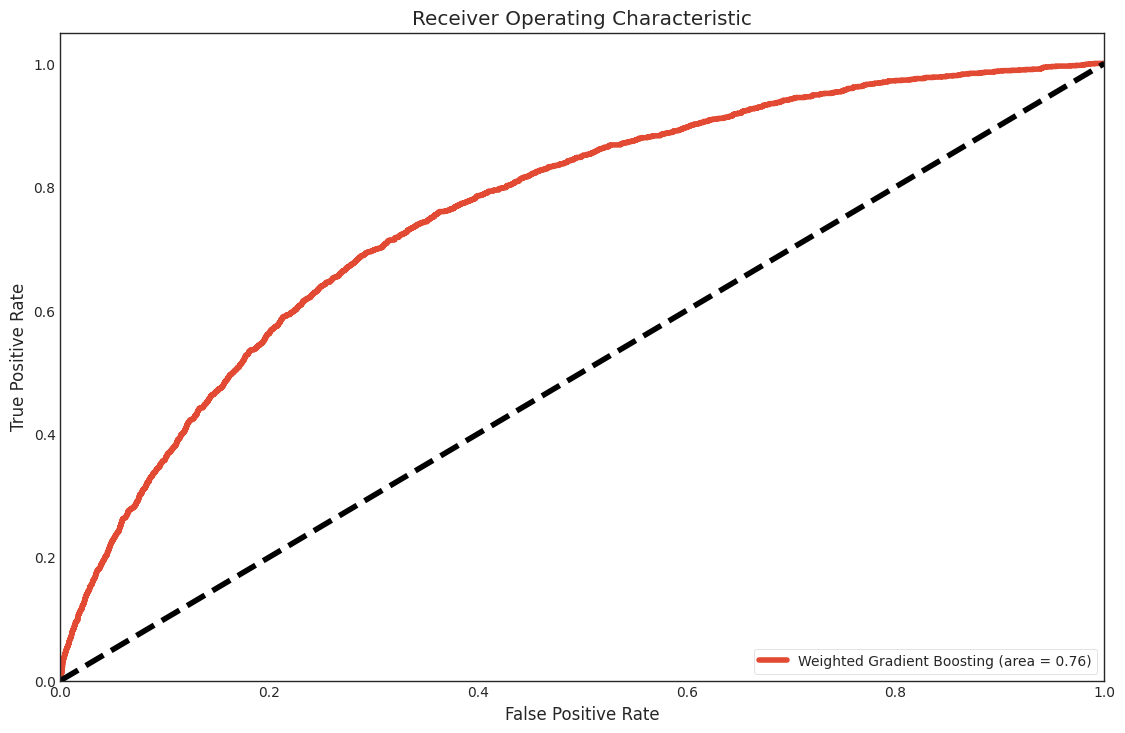

In [68]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
weight = 28
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация параметров модели
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'scale_pos_weight': weight # установка веса класса
}

# Преобразование данных в формат DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Обучение модели
bst = xgb.train(params, dtrain, num_boost_round=100)

# Предсказание на тестовых данных
y_pred_xgb = bst.predict(dtest)

# Преобразование вероятностей в бинарные предсказания
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]

# Расчёт метрик качества
print("Weighted Gradient Boosting - Классификационный отчет:\n", classification_report(y_test, y_pred_binary))
print("Weighted Gradient Boosting - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("Weighted Gradient Boosting - ROC AUC:", roc_auc_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='Weighted Gradient Boosting (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [69]:
columns_more_then_85 = ['id', 'rn', 'pre_since_opened', 'pre_since_confirmed', 'pre_pterm',
       'pre_fterm', 'pre_till_pclose', 'pre_till_fclose',
       'pre_loans_credit_limit', 'pre_loans_next_pay_summ',
       'pre_loans_outstanding', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
       'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5',
       'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090',
       'is_zero_loans90', 'pre_util', 'pre_maxover2limit', 'is_zero_util',
       'is_zero_maxover2limit', 'enc_paym_0', 'enc_paym_1', 'enc_paym_2',
       'enc_paym_3', 'enc_paym_24', 'enc_loans_account_holder_type',
       'enc_loans_credit_status', 'enc_loans_credit_type',
       'enc_loans_account_cur', 'pclose_flag', 'fclose_flag', 'flag']

In [70]:
categorical_features = ['enc_loans_account_cur',
 'enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_paym_0',
 'enc_paym_1',
 'enc_paym_2',
 'enc_paym_24',
 'enc_paym_3',
 'pre_fterm',
 'pre_loans3060',
 'pre_loans5',
 'pre_loans530',
 'pre_loans6090',
 'pre_loans90',
 'pre_loans_credit_cost_rate',
 'pre_loans_credit_limit',
 'pre_loans_max_overdue_sum',
 'pre_loans_next_pay_summ',
 'pre_loans_outstanding',
 'pre_maxover2limit',
 'pre_pterm',
 'pre_since_confirmed',
 'pre_since_opened',
 'pre_till_fclose',
 'pre_till_pclose',
 'pre_util']

In [71]:
import os
import pandas as pd
from tqdm import tqdm
import time
import gc



# Путь к папке с файлами
folder_path = "/content/"
target_file_path = "/content/train_target.csv"

# Список для хранения загруженных данных
all_data = []

# Получим список файлов для отслеживания прогресса
file_list = [f for f in os.listdir(folder_path) if f.endswith('.pq')]

# Используем цикл для обработки файлов без общего бара прогресса
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)

# Начало измерения времени обработки файла
start_time = time.time()

# Создаем бар для обработки текущего файла
with tqdm(total=100, desc=f"Файл {file_name}", unit="%", colour='green', bar_format='{desc}: {percentage:3.0f}%|{bar:50}{r_bar}') as pbar_file:

    # Шаг 1: Чтение файла (обновление бара на 33%)
    merged_data = read_file(file_path)  # Предполагаемая функция read_file для чтения файла
    for _ in range(20):
        time.sleep(0.05)  # Искусственная задержка для демонстрации прогресса
        pbar_file.update(1)

    # Шаг 2: Добавление столбца с таргетом (обновление бара на 33%)
    merged_data_with_target = add_target_column(merged_data, target_file_path)  # Предполагаемая функция add_target_column для добавления столбца с таргетом
    for _ in range(20):
        time.sleep(0.05)  # Искусственная задержка для демонстрации прогресса
        pbar_file.update(1)

    # Шаг 3: Преобразование выбранных столбцов в тип данных int8 (обновление бара на оставшиеся 34%)
    columns_to_convert = merged_data_with_target.columns.drop('id')
    merged_data_with_target[columns_to_convert] = merged_data_with_target[columns_to_convert].astype('int8')
    for _ in range(20):
        time.sleep(0.05)  # Искусственная задержка для демонстрации прогресса
        pbar_file.update(1)


    # Шаг 4: Выбираем признаки с корреляцией меньше 85%
    merged_data_with_target = merged_data_with_target[columns_more_then_85]
    # Применение one-hot encoding к категориальным признакам и удаление исходных столбцов
    merged_data_with_target = pd.get_dummies(merged_data_with_target, columns=categorical_features, drop_first=True)
    for _ in range(20):
        time.sleep(0.05)  # Искусственная задержка для демонстрации прогресса
        pbar_file.update(1)





    # Шаг 5: Группировка по id и вычесление среднего (обновление бара на оставшиеся 34%)
    # Среднее
    df_mean = merged_data_with_target.groupby('id').mean().reset_index()

    for _ in range(20):
        time.sleep(0.05)  # Искусственная задержка для демонстрации прогресса
        pbar_file.update(1)

    # Добавление обработанных данных в список
    all_data.append(df_mean)

    # Очистка промежуточных данных для освобождения ОЗУ
    del merged_data
    del merged_data_with_target
    gc.collect()

    # Завершение измерения времени обработки файла
    end_time = time.time()

    # Вывод времени выполнения текущего файла
    tqdm.write(f"Файл {file_name} обработан. Время выполнения: {end_time - start_time:.2f} секунд.")



# Объединение всех обработанных данных в один DataFrame
merged_data_all = pd.concat(all_data, ignore_index=True)

# Очистка списка all_data для освобождения ОЗУ
del all_data
gc.collect()

# Создание копии DataFrame для дальнейшей обработки
merged_data_int8 = merged_data_all.copy()

# Вывод сообщения о завершении обработки
print("Обработка всех файлов завершена.")


Файл train_data_4.pq: 100%|██████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.74%/s]


Файл train_data_4.pq обработан. Время выполнения: 21.09 секунд.
Обработка всех файлов завершена.


In [72]:
merged_data_all.shape

(250000, 264)

In [73]:
get_memory_usage(merged_data_all)

"File 'merged_data_all': memory_usage: 503.54 Mb"

In [74]:
# 1. Удаление столбцов 'id' и 'rn'
df = merged_data_all.drop(['id', 'rn'], axis=1)

# 2. Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']

In [75]:
import pandas as pd
import sys

# Получение всех датафреймов в текущем пространстве имен
dataframes = [obj for obj in globals().values() if isinstance(obj, pd.DataFrame)]

total_memory_usage = 0
for df in dataframes:
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    total_memory_usage += memory_usage

print("Общее использование памяти всех датафреймов: {:.2f} MB".format(total_memory_usage))


Общее использование памяти всех датафреймов: 5151.94 MB


In [77]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'merged_data_int8' использует 503.54 MB памяти
Датафрейм 'df' использует 503.54 MB памяти
Датафрейм 'df_mean' использует 503.54 MB памяти
Датафрейм '_29' использует 0.00 MB памяти
Датафрейм 'X' использует 497.82 MB памяти
Датафрейм 'X_train' использует 433.35 MB памяти
Датафрейм 'X_test' использует 108.34 MB памяти
Датафрейм 'data_types_df' использует 0.02 MB памяти
Датафрейм 'correlation_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.27 MB памяти
Датафрейм 'sorted_corr' использует 0.27 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'reduced_data' использует 92.45 MB памяти
Датафрейм 'correlation_matrix_reduced' использует 0.02 MB памяти
Датафрейм 'merged_data_int8_encoded' использует 588.84 MB памяти
Датафрейм '_51' использует 588.84 MB памяти
Датафрейм 'new_features' использует 444.14 MB памяти
Датафрейм 'df_mean_new_features' использует 61.04 MB памяти
Датафрейм 'reduced_data_

In [78]:
# Найти столбцы, которые содержат пропуски
missing_columns =merged_data_all.columns[merged_data_all.isna().any()].tolist()

print("Столбцы с пропусками:", missing_columns)

Столбцы с пропусками: []


In [79]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'merged_data_int8' использует 503.54 MB памяти
Датафрейм 'df' использует 503.54 MB памяти
Датафрейм 'df_mean' использует 503.54 MB памяти
Датафрейм '_29' использует 0.00 MB памяти
Датафрейм 'X' использует 497.82 MB памяти
Датафрейм 'X_train' использует 433.35 MB памяти
Датафрейм 'X_test' использует 108.34 MB памяти
Датафрейм 'data_types_df' использует 0.02 MB памяти
Датафрейм 'correlation_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.27 MB памяти
Датафрейм 'sorted_corr' использует 0.27 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'reduced_data' использует 92.45 MB памяти
Датафрейм 'correlation_matrix_reduced' использует 0.02 MB памяти
Датафрейм 'merged_data_int8_encoded' использует 588.84 MB памяти
Датафрейм '_51' использует 588.84 MB памяти
Датафрейм 'new_features' использует 444.14 MB памяти
Датафрейм 'df_mean_new_features' использует 61.04 MB памяти
Датафрейм 'reduced_data_

Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.71      0.82     47998
         1.0       0.08      0.63      0.15      2002

    accuracy                           0.71     50000
   macro avg       0.53      0.67      0.49     50000
weighted avg       0.94      0.71      0.80     50000

Confusion Matrix:
 [[34174 13824]
 [  731  1271]]
ROC AUC: 0.7360843716889801


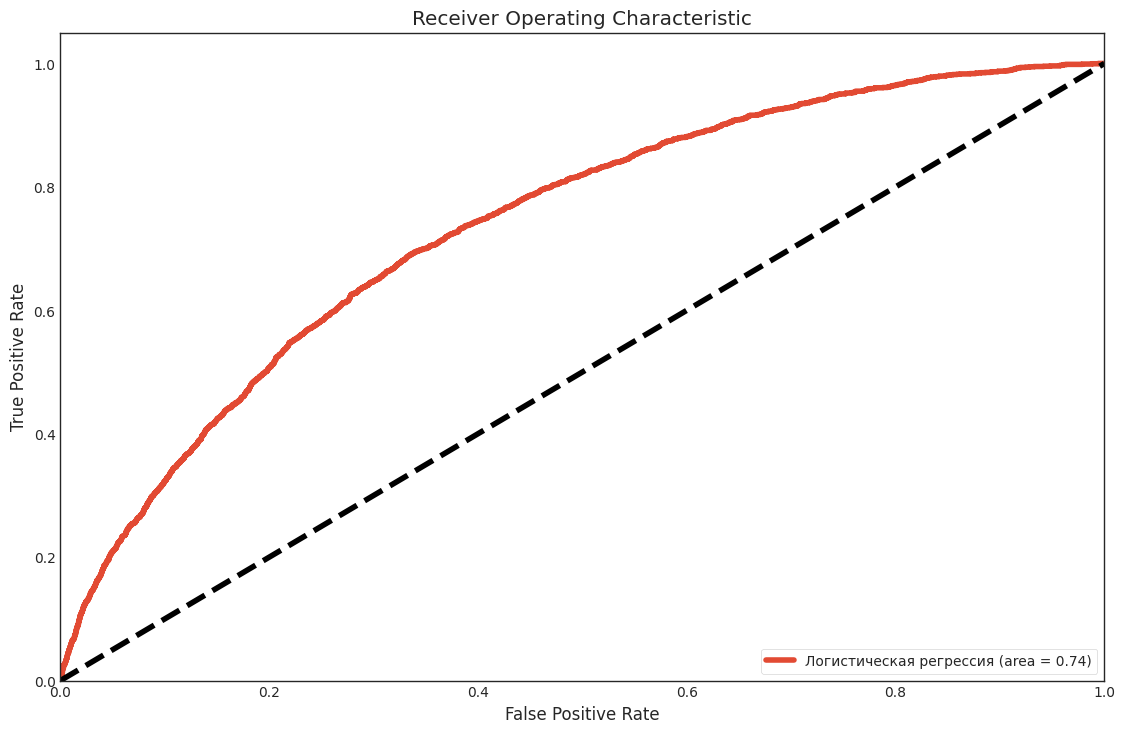

In [80]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt


# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели логистической регрессии
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Расчёт метрик качества
print("Классификационный отчет:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("ROC AUC:", roc_auc)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Логистическая регрессия (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Weighted Gradient Boosting - Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.98      0.66      0.79     47998
         1.0       0.08      0.71      0.14      2002

    accuracy                           0.66     50000
   macro avg       0.53      0.69      0.47     50000
weighted avg       0.95      0.66      0.76     50000

Weighted Gradient Boosting - Confusion Matrix:
 [[31679 16319]
 [  580  1422]]
Weighted Gradient Boosting - ROC AUC: 0.7459641956027221


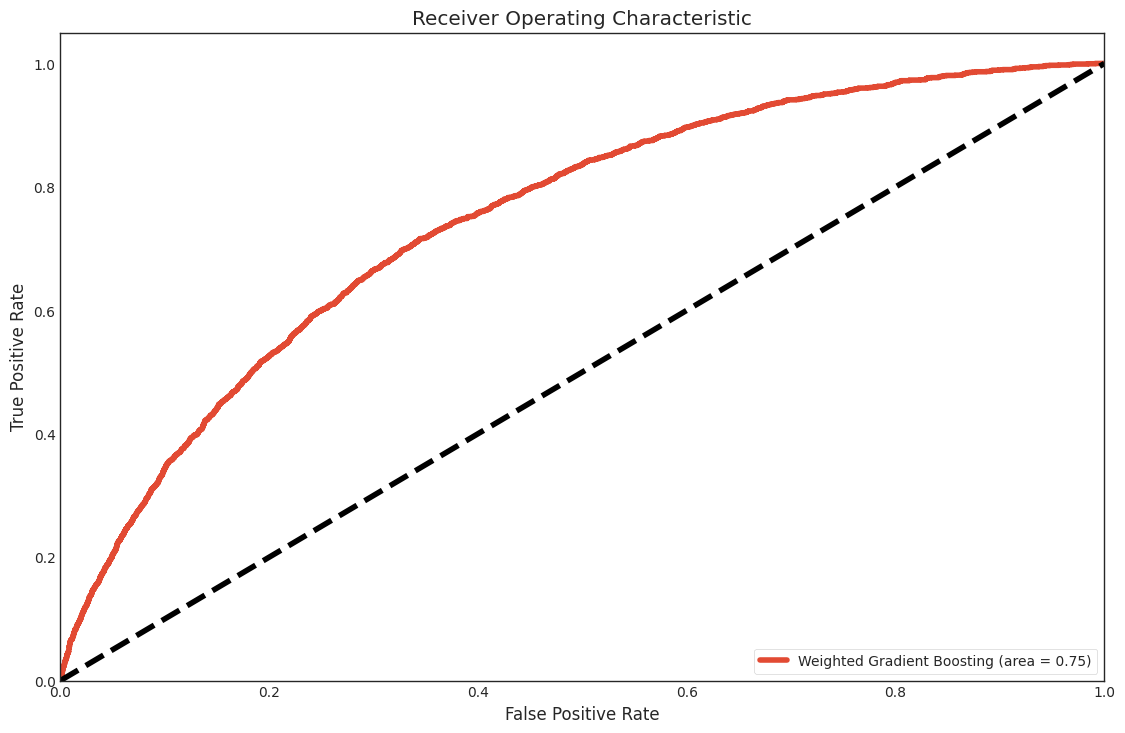

In [81]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
weight = 28
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация параметров модели
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.6,
    'scale_pos_weight': weight # установка веса класса
}

# Преобразование данных в формат DMatrix для XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Обучение модели
bst = xgb.train(params, dtrain, num_boost_round=100)

# Предсказание на тестовых данных
y_pred_xgb = bst.predict(dtest)

# Преобразование вероятностей в бинарные предсказания
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred_xgb]

# Расчёт метрик качества
print("Weighted Gradient Boosting - Классификационный отчет:\n", classification_report(y_test, y_pred_binary))
print("Weighted Gradient Boosting - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_binary))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_xgb)
print("Weighted Gradient Boosting - ROC AUC:", roc_auc_xgb)

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label='Weighted Gradient Boosting (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [82]:
print_system_info()

Занято ОЗУ: 8.10 GB
Свободно ОЗУ: 4.30 GB
Нагрузка на процессор: 3.00%


In [83]:
#ОЗУ загружено. Освободим для дальнейшей работы.

In [84]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'merged_data_int8' использует 503.54 MB памяти
Датафрейм 'df' использует 503.54 MB памяти
Датафрейм 'df_mean' использует 503.54 MB памяти
Датафрейм '_29' использует 0.00 MB памяти
Датафрейм 'X' использует 497.82 MB памяти
Датафрейм 'X_train' использует 399.78 MB памяти
Датафрейм 'X_test' использует 99.95 MB памяти
Датафрейм 'data_types_df' использует 0.02 MB памяти
Датафрейм 'correlation_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.27 MB памяти
Датафрейм 'sorted_corr' использует 0.27 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'reduced_data' использует 92.45 MB памяти
Датафрейм 'correlation_matrix_reduced' использует 0.02 MB памяти
Датафрейм 'merged_data_int8_encoded' использует 588.84 MB памяти
Датафрейм '_51' использует 588.84 MB памяти
Датафрейм 'new_features' использует 444.14 MB памяти
Датафрейм 'df_mean_new_features' использует 61.04 MB памяти
Датафрейм 'reduced_data_'

In [85]:
# Освобождение памяти, занятой переменными
del df, merged_data_int8_encoded, _51, merged_data_all


Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.9578 - loss: 0.1837 - val_accuracy: 0.9579 - val_loss: 0.1615
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9590 - loss: 0.1636 - val_accuracy: 0.9579 - val_loss: 0.1608
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9586 - loss: 0.1628 - val_accuracy: 0.9579 - val_loss: 0.1610
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9598 - loss: 0.1576 - val_accuracy: 0.9579 - val_loss: 0.1605
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.9595 - loss: 0.1576 - val_accuracy: 0.9579 - val_loss: 0.1618
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9608 - loss: 0.1537
Loss: 0.15665972232818604
Accuracy: 0.9599599838256836
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Нейронная сеть - Классификационный отчет:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     47998
         1.0       0.00

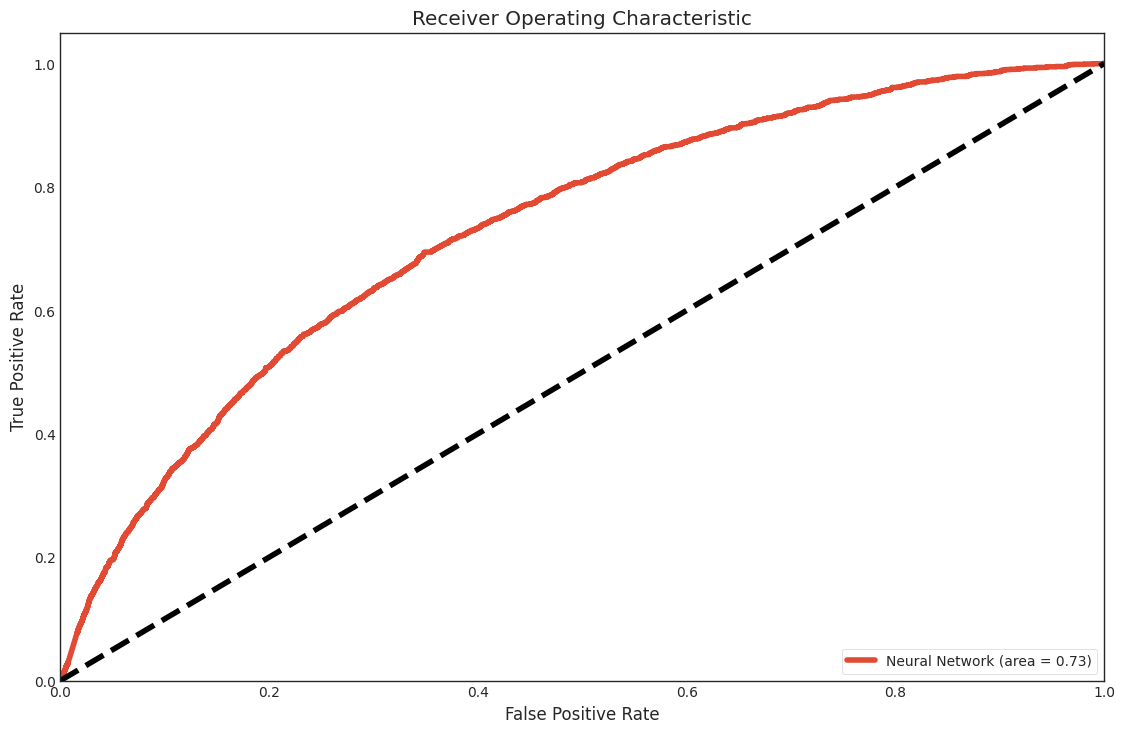

In [86]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Определение архитектуры нейронной сети
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Оценка качества модели на тестовых данных
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Предсказание на тестовых данных
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")

# Расчёт метрик качества
print("Нейронная сеть - Классификационный отчет:\n", classification_report(y_test, y_pred_nn))
print("Нейронная сеть - Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))

# ROC AUC
roc_auc_nn = roc_auc_score(y_test, model.predict(X_test))
print("Нейронная сеть - ROC AUC:", roc_auc_nn)

# ROC Curve
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, model.predict(X_test))
plt.figure()
plt.plot(fpr_nn, tpr_nn, label='Neural Network (area = %0.2f)' % roc_auc_nn)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Нейронная сеть на всем датафрейме из 3 млн показывает значение хуже чем отдельно каждый из 12 датафреймов

<a id="ch0011"></a
#Сборка окончательного датасета и обучение модели - XGBClassifier

Модель XGBoost (XGBClassifier): превосходит другие алгоритмы машинного обучения, включает в себя различные регуляризационные параметры (L1 и L2), которые помогают контролировать переобучение, эффективно обрабатывает пропущенные значения и выбросы в данных, поддерживает параллельные вычисления. Буду использовать ее.

In [87]:
import os
import pandas as pd
from tqdm import tqdm
import time
import gc

# Путь к папке с файлами
folder_path = '/content/'
target_file_path = "/content/train_target.csv"

# Список для хранения загруженных данных
all_data = []

# Получим список файлов для отслеживания прогресса
file_list = [f for f in os.listdir(folder_path) if f.endswith('.pq')]

def read_file(file_path):
    return pd.read_parquet(file_path)

def add_target_column(merged_data, target_file_path):
    target_data = pd.read_csv(target_file_path)
    return merged_data.merge(target_data, on='id', how='left')

# Используем цикл для обработки файлов
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)

    # Начало измерения времени обработки файла
    start_time = time.time()

    # Создаем бар для обработки текущего файла
    with tqdm(total=100, desc=f"Файл {file_name}", unit="%", colour='green', bar_format='{desc}: {percentage:3.0f}%|{bar:50}{r_bar}') as pbar_file:

        # Шаг 1: Чтение файла
        merged_data = read_file(file_path)
        pbar_file.update(33)

        # Шаг 2: Добавление столбца с таргетом
        merged_data_with_target = add_target_column(merged_data, target_file_path)
        pbar_file.update(33)

        # Шаг 3: Преобразование выбранных столбцов в тип данных int8
        columns_to_convert = merged_data_with_target.columns.drop('id')
        for column in columns_to_convert:
            merged_data_with_target[column] = pd.to_numeric(merged_data_with_target[column], downcast='integer')
        pbar_file.update(34)

        # Шаг 4: Группировка по id и вычисление медианы
        df_mean = merged_data_with_target.groupby('id').median().reset_index()
        pbar_file.update(34)

        # Добавление обработанных данных в список
        all_data.append(df_mean)

        # Очистка промежуточных данных для освобождения ОЗУ
        del merged_data
        del merged_data_with_target
        gc.collect()

        # Завершение измерения времени обработки файла
        end_time = time.time()

        # Вывод времени выполнения текущего файла
        tqdm.write(f"Файл {file_name} обработан. Время выполнения: {end_time - start_time:.2f} секунд.")

# Объединение всех обработанных данных в один DataFrame
merged_data_int8 = pd.concat(all_data, ignore_index=True)

# Очистка списка all_data для освобождения ОЗУ
del all_data
gc.collect()

# Вывод сообщения о завершении обработки
print("Обработка всех файлов завершена.")


Файл train_data_11.pq:   0%|                                                  | 134/? [00:10<00:00, 12.30%/s]


Файл train_data_11.pq обработан. Время выполнения: 10.89 секунд.


Файл train_data_9.pq:   0%|                                                  | 134/? [00:11<00:00, 12.03%/s]


Файл train_data_9.pq обработан. Время выполнения: 11.13 секунд.


Файл train_data_3.pq:   0%|                                                  | 134/? [00:09<00:00, 14.53%/s]


Файл train_data_3.pq обработан. Время выполнения: 9.22 секунд.


Файл train_data_8.pq:   0%|                                                  | 134/? [00:09<00:00, 14.22%/s]


Файл train_data_8.pq обработан. Время выполнения: 9.42 секунд.


Файл train_data_1.pq:   0%|                                                  | 134/? [00:08<00:00, 15.91%/s]


Файл train_data_1.pq обработан. Время выполнения: 8.32 секунд.


Файл train_data_10.pq:   0%|                                                  | 134/? [00:10<00:00, 13.29%/s]


Файл train_data_10.pq обработан. Время выполнения: 10.08 секунд.


Файл train_data_6.pq:   0%|                                                  | 134/? [00:09<00:00, 14.86%/s]


Файл train_data_6.pq обработан. Время выполнения: 9.01 секунд.


Файл train_data_2.pq:   0%|                                                  | 134/? [00:07<00:00, 18.12%/s]


Файл train_data_2.pq обработан. Время выполнения: 7.39 секунд.


Файл train_data_0.pq:   0%|                                                  | 134/? [00:10<00:00, 13.27%/s]


Файл train_data_0.pq обработан. Время выполнения: 10.09 секунд.


Файл train_data_5.pq:   0%|                                                  | 134/? [00:09<00:00, 14.19%/s]


Файл train_data_5.pq обработан. Время выполнения: 9.44 секунд.


Файл train_data_7.pq:   0%|                                                  | 134/? [00:08<00:00, 15.40%/s]


Файл train_data_7.pq обработан. Время выполнения: 8.70 секунд.


Файл train_data_4.pq:   0%|                                                  | 134/? [00:08<00:00, 16.40%/s]


Файл train_data_4.pq обработан. Время выполнения: 8.17 секунд.
Обработка всех файлов завершена.


In [96]:
print_system_info()

Занято ОЗУ: 6.29 GB
Свободно ОЗУ: 6.10 GB
Нагрузка на процессор: 3.00%


In [97]:
## ОЗУ загружено, высвободим ресурс

In [98]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'df_mean' использует 118.26 MB памяти
Датафрейм '_29' использует 0.00 MB памяти
Датафрейм 'X_test' использует 99.95 MB памяти
Датафрейм 'data_types_df' использует 0.02 MB памяти
Датафрейм 'correlation_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.27 MB памяти
Датафрейм 'sorted_corr' использует 0.27 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'reduced_data' использует 92.45 MB памяти
Датафрейм 'correlation_matrix_reduced' использует 0.02 MB памяти
Датафрейм 'df_mean_new_features' использует 61.04 MB памяти
Датафрейм 'reduced_data_' использует 74.39 MB памяти
Датафрейм 'merged_df' использует 133.51 MB памяти
Датафрейм 'X_train_filtered' использует 94.60 MB памяти
Датафрейм 'X_test_filtered' использует 23.65 MB памяти
Датафрейм 'df' использует 23.65 MB памяти


In [99]:
# Освобождение памяти, занятой переменными


Загрузим все данные, агрегируем по id, изменим тип данных на int8

In [100]:
import os
import pandas as pd
from tqdm import tqdm
import time
import gc

folder_path = '/content/'
target_file_path = "/content/train_target.csv"
output_folder = '/content/processed/'

os.makedirs(output_folder, exist_ok=True)

file_list = [f for f in os.listdir(folder_path) if f.endswith('.pq')]

for file_name in tqdm(file_list, desc="Обработка файлов"):
    file_path = os.path.join(folder_path, file_name)
    start_time = time.time()

def read_file(file_path):
    return pd.read_parquet(file_path)

def add_target_column(merged_data, target_file_path):
    target_data = pd.read_csv(target_file_path)
    return merged_data.merge(target_data, on='id', how='left')

for file_name in tqdm(file_list, desc="Обработка файлов"):
    file_path = os.path.join(folder_path, file_name)
    start_time = time.time()

    # Чтение файла
    merged_data = read_file(file_path)

    # Добавление таргета
    merged_data_with_target = add_target_column(merged_data, target_file_path)

    # Преобразование типов
    columns_to_convert = merged_data_with_target.columns.drop('id')
    merged_data_with_target[columns_to_convert] = merged_data_with_target[columns_to_convert].astype('int8')

    # Сохраняем результат на диск
    output_path = os.path.join(output_folder, f'processed_{file_name}')
    merged_data_with_target.to_parquet(output_path)

    # Очистка памяти
    del merged_data, merged_data_with_target
    gc.collect()

    end_time = time.time()
    print(f"Файл {file_name} обработан за {end_time - start_time:.2f} секунд.")

# После обработки всех файлов можно объединить их по необходимости
# Например, лениво или по частям

print("Обработка всех файлов завершена.")


Обработка файлов:   8%|▊         | 1/12 [00:13<02:30, 13.65s/it]

Файл train_data_11.pq обработан за 13.65 секунд.


Обработка файлов:  17%|█▋        | 2/12 [00:20<01:36,  9.65s/it]

Файл train_data_9.pq обработан за 6.85 секунд.


Обработка файлов:  25%|██▌       | 3/12 [00:28<01:18,  8.68s/it]

Файл train_data_3.pq обработан за 7.51 секунд.


Обработка файлов:  33%|███▎      | 4/12 [00:34<01:02,  7.87s/it]

Файл train_data_8.pq обработан за 6.63 секунд.


Обработка файлов:  42%|████▏     | 5/12 [00:42<00:54,  7.72s/it]

Файл train_data_1.pq обработан за 7.45 секунд.


Обработка файлов:  50%|█████     | 6/12 [00:48<00:44,  7.43s/it]

Файл train_data_10.pq обработан за 6.86 секунд.


Обработка файлов:  58%|█████▊    | 7/12 [00:57<00:38,  7.75s/it]

Файл train_data_6.pq обработан за 8.40 секунд.


Обработка файлов:  67%|██████▋   | 8/12 [01:04<00:30,  7.62s/it]

Файл train_data_2.pq обработан за 7.36 секунд.


Обработка файлов:  75%|███████▌  | 9/12 [01:11<00:22,  7.35s/it]

Файл train_data_0.pq обработан за 6.69 секунд.


Обработка файлов:  83%|████████▎ | 10/12 [01:18<00:14,  7.10s/it]

Файл train_data_5.pq обработан за 6.55 секунд.


Обработка файлов:  92%|█████████▏| 11/12 [01:25<00:07,  7.30s/it]

Файл train_data_7.pq обработан за 7.74 секунд.


Обработка файлов: 100%|██████████| 12/12 [01:31<00:00,  7.61s/it]

Файл train_data_4.pq обработан за 5.52 секунд.
Обработка всех файлов завершена.


In [101]:
print_system_info()

Занято ОЗУ: 6.37 GB
Свободно ОЗУ: 6.02 GB
Нагрузка на процессор: 64.80%


In [ ]:
## ОЗУ загружено, высвободим ресурс

In [102]:
# Получение всех датафреймов в текущем пространстве имен
dataframes = {name: obj for name, obj in globals().items() if isinstance(obj, pd.DataFrame)}

for name, df in dataframes.items():
    memory_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)  # Преобразование в мегабайты
    print("Датафрейм '{}' использует {:.2f} MB памяти".format(name, memory_usage))

Датафрейм 'df_mean' использует 118.26 MB памяти
Датафрейм '_29' использует 0.00 MB памяти
Датафрейм 'X_test' использует 99.95 MB памяти
Датафрейм 'data_types_df' использует 0.02 MB памяти
Датафрейм 'correlation_matrix' использует 0.04 MB памяти
Датафрейм 'corr_long' использует 0.27 MB памяти
Датафрейм 'sorted_corr' использует 0.27 MB памяти
Датафрейм 'high_corr' использует 0.01 MB памяти
Датафрейм 'high_corr_matrix' использует 0.01 MB памяти
Датафрейм 'reduced_data' использует 92.45 MB памяти
Датафрейм 'correlation_matrix_reduced' использует 0.02 MB памяти
Датафрейм 'df_mean_new_features' использует 61.04 MB памяти
Датафрейм 'reduced_data_' использует 74.39 MB памяти
Датафрейм 'merged_df' использует 133.51 MB памяти
Датафрейм 'X_train_filtered' использует 94.60 MB памяти
Датафрейм 'X_test_filtered' использует 23.65 MB памяти
Датафрейм 'df' использует 23.65 MB памяти


In [104]:
# Случайный выбор одной строки для каждого уникального значения id, где flag=1
flag_1_data = merged_df[merged_df['flag'] == 1]
unique_flag_1_data = flag_1_data.groupby('id').sample(n=1, random_state=42)

In [106]:
# Используем pd.concat для склеивания DataFrame
combined_data = pd.concat([merged_df, unique_flag_1_data], ignore_index=True)

# Перемешиваем строки результирующего DataFrame
shuffled_data = combined_data.sample(frac=1).reset_index(drop=True)

In [107]:
# Отфильтруем строки, где flag == 1
flag_1_data = shuffled_data[shuffled_data['flag'] == 1]

# Удалим дубликаты на основании столбца 'id' случайным образом
flag_1_data = flag_1_data.drop_duplicates(subset=['id'], keep='first')

# Отфильтруем строки, где flag != 1
non_flag_1_data = shuffled_data[shuffled_data['flag'] != 1]

# Объединим обратно
cleaned_data = pd.concat([flag_1_data, non_flag_1_data], ignore_index=True)

In [108]:
cleaned_data.flag.value_counts()

flag
0.0    241788
1.0      8212
Name: count, dtype: int64

In [109]:
# 1. Удаление столбцов 'id' и 'rn'
df = cleaned_data.drop(['id', 'rn'], axis=1)

# 2. Разделение данных на признаки и целевую переменную
X = df.drop('flag', axis=1)
y = df['flag']

In [110]:
# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Классификационный отчет для XGBoost:
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94     48429
         1.0       0.08      0.28      0.13      1571

    accuracy                           0.88     50000
   macro avg       0.53      0.59      0.53     50000
weighted avg       0.95      0.88      0.91     50000

Confusion Matrix для XGBoost:
 [[43667  4762]
 [ 1131   440]]
ROC AUC для XGBoost: 0.6971882913793006


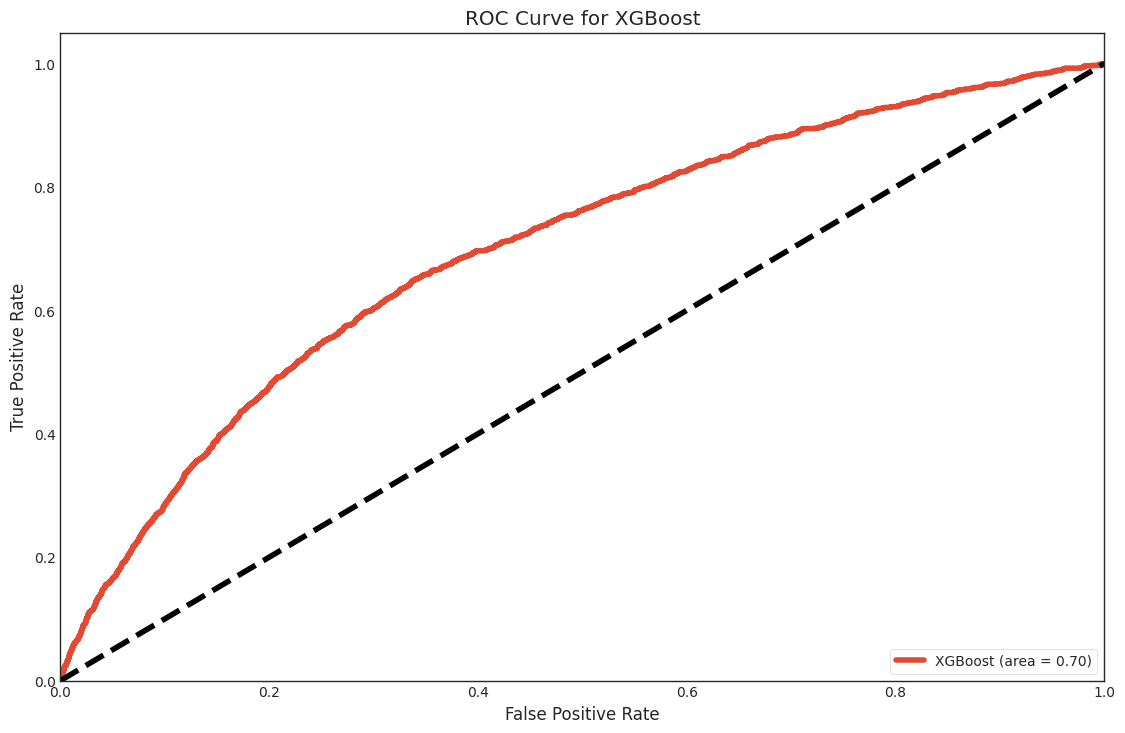

In [111]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


positive_class_weight = 18

# Создание экземпляра модели XGBClassifier с установленным весом положительного класса
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=positive_class_weight)

# Обучение модели
xgb_model.fit(X_train, y_train)


# Предсказания на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)

# Вероятности для расчета ROC AUC
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Классификационный отчет
print("Классификационный отчет для XGBoost:\n", classification_report(y_test, y_pred_xgb))

# Матрица ошибок
print("Confusion Matrix для XGBoost:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC AUC для XGBoost:", roc_auc_xgb)

# Построение ROC-кривой
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

<a id="ch0012"></a>
## Комбинирование признаков для улучшения метрик

In [114]:
# Бинаризованные признаки:

binary_columns = [col for col in merged_df.columns if merged_df[col].nunique() == 2]
# Удаляем столбец 'flag' из списка binary_columns
binary_columns.remove('flag')
binary_columns

[]

In [115]:
len(binary_columns)

0

In [117]:
# Создаем список столбцов, которые нужно исключить
columns_to_exclude = ['flag', 'id', 'rn'] + binary_columns

# Получаем список столбцов, которые остаются после исключения
categorical_features = merged_df.columns.difference(columns_to_exclude).tolist()
len(categorical_features)

67

In [118]:
categorical_features

['avg_days_since_open',
 'diff_till_close',
 'enc_loans_account_cur',
 'enc_loans_account_holder_type',
 'enc_loans_credit_status',
 'enc_loans_credit_type',
 'enc_paym_0',
 'enc_paym_0_flag',
 'enc_paym_1',
 'enc_paym_10_flag',
 'enc_paym_12_flag',
 'enc_paym_13_flag',
 'enc_paym_14_flag',
 'enc_paym_15_flag',
 'enc_paym_16_flag',
 'enc_paym_17_flag',
 'enc_paym_18_flag',
 'enc_paym_19_flag',
 'enc_paym_1_flag',
 'enc_paym_2',
 'enc_paym_21_flag',
 'enc_paym_22_flag',
 'enc_paym_23_flag',
 'enc_paym_24',
 'enc_paym_24_flag',
 'enc_paym_2_flag',
 'enc_paym_3',
 'enc_paym_3_flag',
 'enc_paym_4_flag',
 'enc_paym_5_flag',
 'enc_paym_6_flag',
 'enc_paym_7_flag',
 'enc_paym_8_flag',
 'enc_paym_9_flag',
 'fclose_flag',
 'is_zero_loans3060',
 'is_zero_loans5',
 'is_zero_loans530',
 'is_zero_loans6090',
 'is_zero_loans90',
 'is_zero_maxover2limit',
 'is_zero_util',
 'max_next_pay_summ',
 'max_overdue_to_credit_limit',
 'min_next_pay_summ',
 'outstanding_to_credit_limit',
 'pclose_flag',
 'pre_

KeyError: 'enc_paym_10'

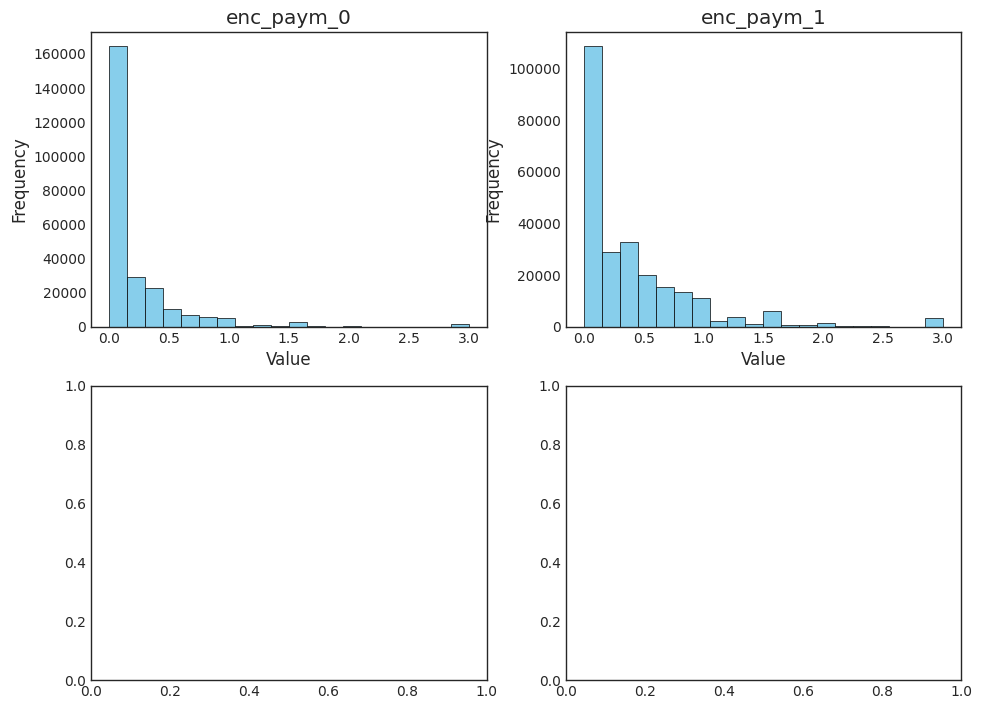

In [120]:
import matplotlib.pyplot as plt

# Список столбцов для построения графиков
enc_paym_columns = ['enc_paym_0', 'enc_paym_1', 'enc_paym_10', 'enc_paym_11']

# Создаем подграфики
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Построение гистограмм для каждого столбца
for i, column in enumerate(enc_paym_columns):
    ax = axes[i // 2, i % 2]  # Выбор подграфика
    ax.hist(merged_df[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(column)
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Размещение подписей осей и заголовка
plt.tight_layout()

# Показываем графики
plt.show()



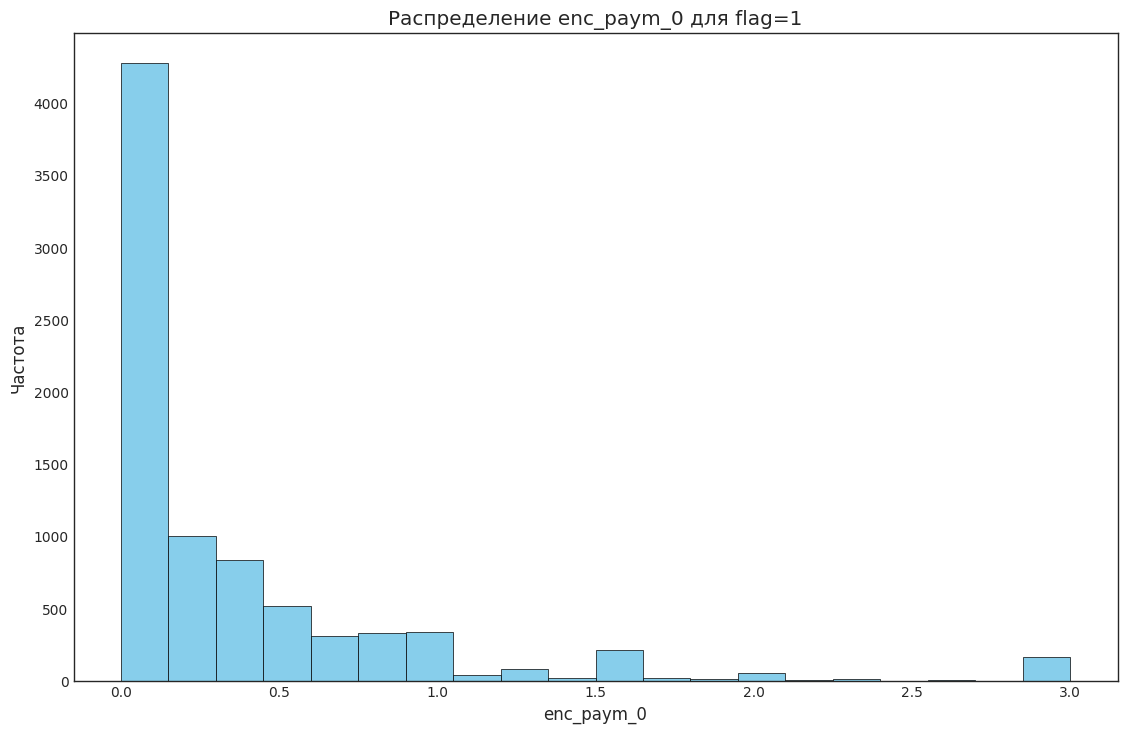

In [122]:
import matplotlib.pyplot as plt

# Фильтрация строк, где flag равен 1
flag_1_data = merged_df[merged_df['flag'] == 1]

# Построение гистограммы для столбца enc_paym_0
plt.hist(flag_1_data['enc_paym_0'], bins=20, color='skyblue', edgecolor='black')

# Добавление заголовка и подписей осей
plt.title('Распределение enc_paym_0 для flag=1')
plt.xlabel('enc_paym_0')
plt.ylabel('Частота')

# Показать график
plt.show()


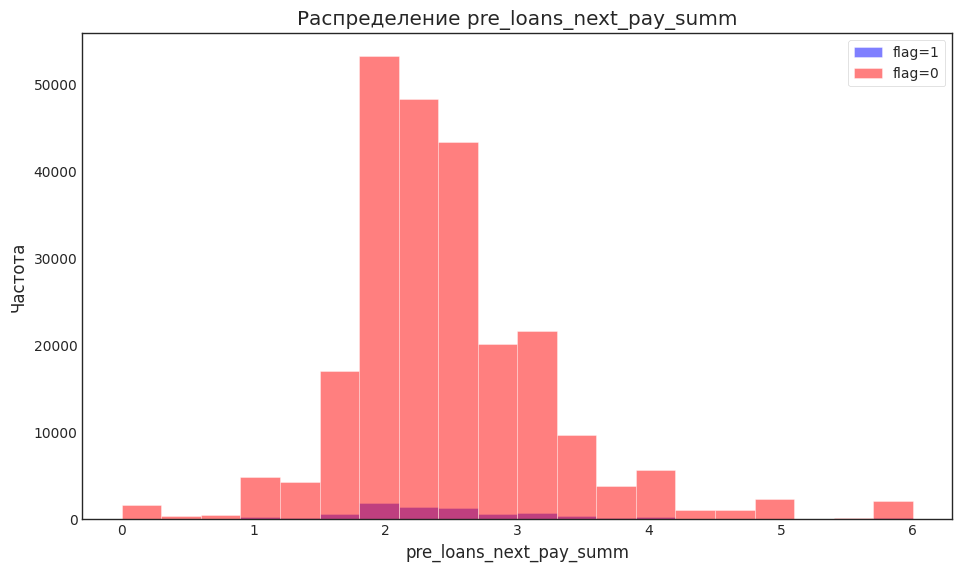

In [123]:
plot_distribution(merged_df, 'pre_loans_next_pay_summ')

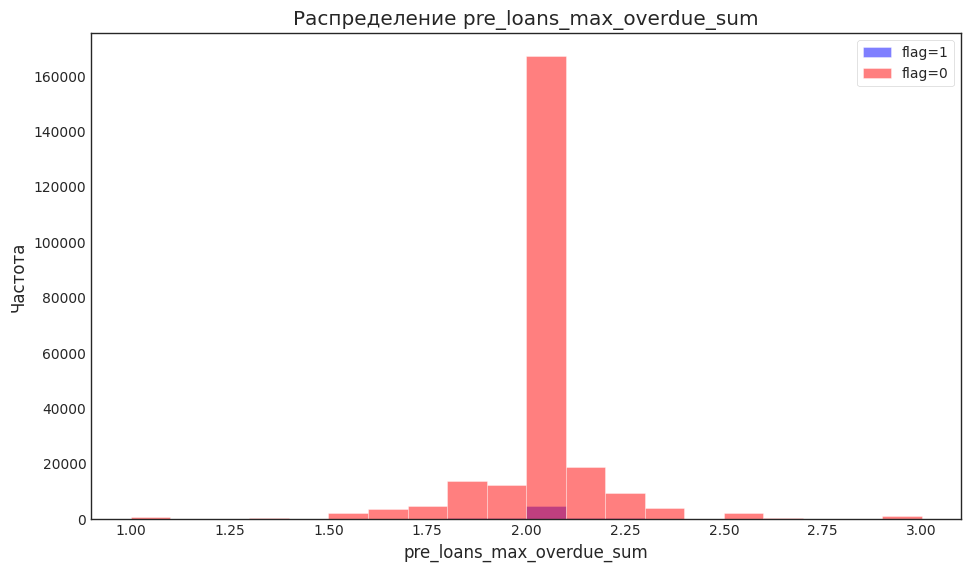

In [124]:
plot_distribution(merged_df, 'pre_loans_max_overdue_sum')

In [125]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

# Оценка важности признаков
feature_importance = model.coef_[0]

# Вывод важности признаков
for i, feature in enumerate(X.columns):
    print(f'{feature}: {feature_importance[i]}')

# Отбор важных признаков
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Обучение модели на отобранных признаках
model_selected = LogisticRegression()
model_selected.fit(X_train_selected, y_train)

# Оценка качества модели на отобранных признаках
accuracy_selected = model_selected.score(X_test_selected, y_test)
print(f'Accuracy on selected features: {accuracy_selected}')


total_overdue: -8.135784414365126e-15
avg_days_since_open: -1.841740654362832e-15
total_zero_loans: -9.776757479184528e-16
max_next_pay_summ: -1.2559962954007421e-15
min_next_pay_summ: 0.0
diff_till_close: -4.252116949382034e-16
outstanding_to_credit_limit: -4.659312708823057e-10
max_overdue_to_credit_limit: -7.861623848167793e-10
enc_paym_0_flag: -1.8964466202269026e-17
enc_paym_1_flag: -3.5332604450061155e-17
enc_paym_2_flag: -4.385285646916141e-17
enc_paym_3_flag: -5.275854985846336e-17
enc_paym_4_flag: -6.284494584024319e-17
enc_paym_5_flag: -7.237166050592629e-17
enc_paym_6_flag: -8.531663707097204e-17
enc_paym_7_flag: -9.523446582851054e-17
enc_paym_8_flag: -1.0345962082682775e-16
enc_paym_9_flag: -1.1094238646460344e-16
enc_paym_10_flag: -1.2082111066684602e-16
enc_paym_12_flag: -1.395987293215415e-16
enc_paym_13_flag: -1.4610546144995275e-16
enc_paym_14_flag: -1.4973401280325629e-16
enc_paym_15_flag: -1.5254439165884295e-16
enc_paym_16_flag: -1.5512463826742013e-16
enc_paym_17_

In [126]:
from sklearn.metrics import roc_auc_score

# Получение вероятностей принадлежности классу 1 (flag=1)
y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]

# Вычисление AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


AUC-ROC: 0.5487912055471652


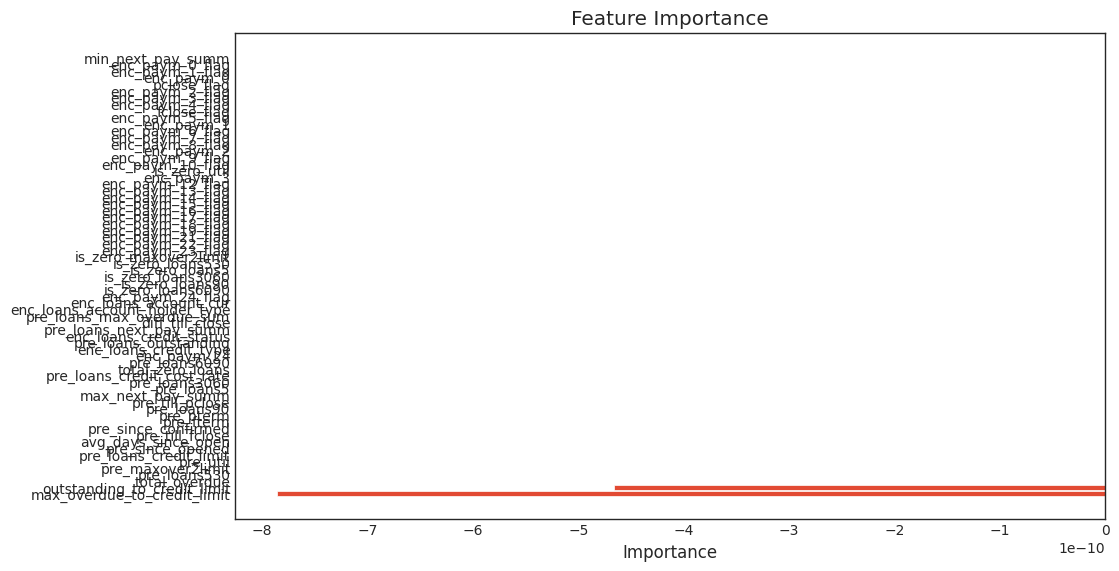

In [127]:
import matplotlib.pyplot as plt

# Сортировка признаков по их важности
sorted_indices = feature_importance.argsort()[::-1]
sorted_features = X.columns[sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# Построение графика
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_features)), sorted_importance, align='center')
plt.yticks(range(len(sorted_features)), sorted_features)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Инвертируем ось y для отображения признаков в порядке убывания важности
plt.show()


In [128]:
from sklearn.feature_selection import SelectKBest, f_classif

# Выбор 10 лучших признаков на основе анализа дисперсии (ANOVA)
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Получение индексов выбранных признаков
selected_features_idx = selector.get_support(indices=True)

# Получение списка выбранных признаков
selected_features = X.columns[selected_features_idx]

# Обучение модели на выбранных признаках
model_selected = LogisticRegression()
model_selected.fit(X_train_selected, y_train)

# Оценка качества модели на выбранных признаках
accuracy_selected = model_selected.score(X_test_selected, y_test)
print(f'Accuracy on selected features: {accuracy_selected}')

# Вывод списка выбранных признаков
print("Selected features:")
for feature in selected_features:
    print(feature)


Accuracy on selected features: 0.96858
Selected features:
enc_paym_1_flag
enc_paym_2_flag
enc_paym_3_flag
enc_paym_4_flag
enc_paym_5_flag
enc_paym_6_flag
enc_paym_7_flag
enc_paym_1
enc_paym_2
enc_paym_3


In [129]:
from sklearn.metrics import roc_auc_score

# Получение вероятностей принадлежности классу 1 (flag=1)
y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]

# Вычисление AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


AUC-ROC: 0.675234722859857


In [130]:
from sklearn.feature_selection import SelectKBest, f_classif

# Выбор 10 лучших признаков на основе анализа дисперсии (ANOVA)
selector = SelectKBest(score_func=f_classif, k=11)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Получение индексов выбранных признаков
selected_features_idx = selector.get_support(indices=True)

# Получение списка выбранных признаков
selected_features = X.columns[selected_features_idx]

# Обучение модели на выбранных признаках
model_selected = LogisticRegression()
model_selected.fit(X_train_selected, y_train)

# Оценка качества модели на выбранных признаках
accuracy_selected = model_selected.score(X_test_selected, y_test)
print(f'Accuracy on selected features: {accuracy_selected}')

# Вывод списка выбранных признаков
print("Selected features:")
for feature in selected_features:
    print(feature)


Accuracy on selected features: 0.96858
Selected features:
enc_paym_1_flag
enc_paym_2_flag
enc_paym_3_flag
enc_paym_4_flag
enc_paym_5_flag
enc_paym_6_flag
enc_paym_7_flag
enc_paym_8_flag
enc_paym_1
enc_paym_2
enc_paym_3


In [131]:
from sklearn.metrics import roc_auc_score

# Получение вероятностей принадлежности классу 1 (flag=1)
y_pred_proba = model_selected.predict_proba(X_test_selected)[:, 1]

# Вычисление AUC-ROC
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc}')


AUC-ROC: 0.6784416723549402


In [132]:
sorted_features

Index(['min_next_pay_summ', 'enc_paym_0_flag', 'enc_paym_1_flag', 'enc_paym_0',
       'pclose_flag', 'enc_paym_2_flag', 'enc_paym_3_flag', 'enc_paym_4_flag',
       'fclose_flag', 'enc_paym_5_flag', 'enc_paym_1', 'enc_paym_6_flag',
       'enc_paym_7_flag', 'enc_paym_8_flag', 'enc_paym_2', 'enc_paym_9_flag',
       'enc_paym_10_flag', 'is_zero_util', 'enc_paym_3', 'enc_paym_12_flag',
       'enc_paym_13_flag', 'enc_paym_14_flag', 'enc_paym_15_flag',
       'enc_paym_16_flag', 'enc_paym_17_flag', 'enc_paym_18_flag',
       'enc_paym_19_flag', 'enc_paym_21_flag', 'enc_paym_22_flag',
       'enc_paym_23_flag', 'is_zero_maxover2limit', 'is_zero_loans530',
       'is_zero_loans5', 'is_zero_loans3060', 'is_zero_loans90',
       'is_zero_loans6090', 'enc_paym_24_flag', 'enc_loans_account_cur',
       'enc_loans_account_holder_type', 'pre_loans_max_overdue_sum',
       'diff_till_close', 'pre_loans_next_pay_summ', 'enc_loans_credit_status',
       'pre_loans_outstanding', 'enc_loans_credit_ty

In [133]:
# Выводим наименование признака и его значение в порядке убывания важности
for feature, importance in zip(sorted_features, sorted_importance):
    print(f'{feature}: {importance}')


min_next_pay_summ: 0.0
enc_paym_0_flag: -1.8964466202269026e-17
enc_paym_1_flag: -3.5332604450061155e-17
enc_paym_0: -3.984906289875197e-17
pclose_flag: -4.3016386487440216e-17
enc_paym_2_flag: -4.385285646916141e-17
enc_paym_3_flag: -5.275854985846336e-17
enc_paym_4_flag: -6.284494584024319e-17
fclose_flag: -6.465233264317606e-17
enc_paym_5_flag: -7.237166050592629e-17
enc_paym_1: -8.080090661273216e-17
enc_paym_6_flag: -8.531663707097204e-17
enc_paym_7_flag: -9.523446582851054e-17
enc_paym_8_flag: -1.0345962082682775e-16
enc_paym_2: -1.0895036065512472e-16
enc_paym_9_flag: -1.1094238646460344e-16
enc_paym_10_flag: -1.2082111066684602e-16
is_zero_util: -1.3154709642060822e-16
enc_paym_3: -1.3690249155877052e-16
enc_paym_12_flag: -1.395987293215415e-16
enc_paym_13_flag: -1.4610546144995275e-16
enc_paym_14_flag: -1.4973401280325629e-16
enc_paym_15_flag: -1.5254439165884295e-16
enc_paym_16_flag: -1.5512463826742013e-16
enc_paym_17_flag: -1.5749337576340849e-16
enc_paym_18_flag: -1.602948

In [134]:
# Выбор признака для обучения модели
X_one_feature = X[['pre_loans530', 'pre_util', 'pre_maxover2limit', 'pre_loans_credit_limit']]

# Разделение данных на обучающий и тестовый наборы
X_train_one_feature, X_test_one_feature, y_train, y_test = train_test_split(X_one_feature, y, test_size=0.2, random_state=42)

# Инициализация и обучение модели логистической регрессии на одном признаке
model_one_feature = LogisticRegression()
model_one_feature.fit(X_train_one_feature, y_train)

# Оценка качества модели
accuracy_one_feature = model_one_feature.score(X_test_one_feature, y_test)
print(f'Accuracy on one feature (pre_loans530): {accuracy_one_feature}')

# Вывод коэффициентов модели
print(f'Coefficient for pre_loans530: {model_one_feature.coef_[0][0]}')


Accuracy on one feature (pre_loans530): 0.96852
Coefficient for pre_loans530: -0.09347787349440335


In [135]:
from sklearn.metrics import roc_auc_score

# Вычисление ROC AUC
y_pred_proba_one_feature = model_one_feature.predict_proba(X_test_one_feature)[:, 1]
roc_auc_one_feature = roc_auc_score(y_test, y_pred_proba_one_feature)
print(f'ROC AUC on one feature (pre_loans530): {roc_auc_one_feature}')


ROC AUC on one feature (pre_loans530): 0.6109319161984249


In [136]:
from sklearn.metrics import roc_auc_score

# Список для хранения значений ROC AUC для каждого признака
roc_auc_list = []

# Перебор признаков и вычисление ROC AUC для каждого
for feature in sorted_features:
    X_train_one_feature = X_train[[feature]]
    X_test_one_feature = X_test[[feature]]

    # Обучение модели логистической регрессии на одном признаке
    model_one_feature = LogisticRegression()
    model_one_feature.fit(X_train_one_feature, y_train)

    # Предсказание вероятности положительного класса для тестового набора данных
    y_pred_proba_one_feature = model_one_feature.predict_proba(X_test_one_feature)[:, 1]

    # Вычисление ROC AUC для данного признака и добавление в список
    roc_auc = roc_auc_score(y_test, y_pred_proba_one_feature)
    roc_auc_list.append((feature, roc_auc))

# Сортировка списка по ROC AUC в порядке убывания
roc_auc_list_sorted = sorted(roc_auc_list, key=lambda x: x[1], reverse=True)

# Вывод списка признаков и их ROC AUC в порядке убывания
for feature, roc_auc in roc_auc_list_sorted:
    print(f'{feature}: ROC AUC = {roc_auc}')


enc_paym_9_flag: ROC AUC = 0.6368089707048684
enc_paym_2_flag: ROC AUC = 0.6359264290237321
enc_paym_4_flag: ROC AUC = 0.6342504995172378
enc_paym_5_flag: ROC AUC = 0.6333821399104616
enc_paym_8_flag: ROC AUC = 0.6323916094221497
enc_paym_3_flag: ROC AUC = 0.6322218648444634
enc_paym_14_flag: ROC AUC = 0.632194854498949
enc_paym_6_flag: ROC AUC = 0.631827020910437
enc_paym_15_flag: ROC AUC = 0.6315316355090174
enc_paym_17_flag: ROC AUC = 0.6311664240927339
enc_paym_18_flag: ROC AUC = 0.6288536813306818
enc_paym_16_flag: ROC AUC = 0.6288475957881159
enc_paym_1_flag: ROC AUC = 0.6280493316424726
enc_paym_12_flag: ROC AUC = 0.6270759668530617
enc_paym_10_flag: ROC AUC = 0.6270549500440702
enc_paym_13_flag: ROC AUC = 0.6264841116932858
enc_paym_19_flag: ROC AUC = 0.6255125278779954
enc_paym_7_flag: ROC AUC = 0.6244927460398332
enc_paym_2: ROC AUC = 0.6178661685091469
enc_paym_22_flag: ROC AUC = 0.6163103857512398
enc_paym_21_flag: ROC AUC = 0.6145448686461925
enc_paym_23_flag: ROC AUC = 0.

In [137]:
sorted_features

Index(['min_next_pay_summ', 'enc_paym_0_flag', 'enc_paym_1_flag', 'enc_paym_0',
       'pclose_flag', 'enc_paym_2_flag', 'enc_paym_3_flag', 'enc_paym_4_flag',
       'fclose_flag', 'enc_paym_5_flag', 'enc_paym_1', 'enc_paym_6_flag',
       'enc_paym_7_flag', 'enc_paym_8_flag', 'enc_paym_2', 'enc_paym_9_flag',
       'enc_paym_10_flag', 'is_zero_util', 'enc_paym_3', 'enc_paym_12_flag',
       'enc_paym_13_flag', 'enc_paym_14_flag', 'enc_paym_15_flag',
       'enc_paym_16_flag', 'enc_paym_17_flag', 'enc_paym_18_flag',
       'enc_paym_19_flag', 'enc_paym_21_flag', 'enc_paym_22_flag',
       'enc_paym_23_flag', 'is_zero_maxover2limit', 'is_zero_loans530',
       'is_zero_loans5', 'is_zero_loans3060', 'is_zero_loans90',
       'is_zero_loans6090', 'enc_paym_24_flag', 'enc_loans_account_cur',
       'enc_loans_account_holder_type', 'pre_loans_max_overdue_sum',
       'diff_till_close', 'pre_loans_next_pay_summ', 'enc_loans_credit_status',
       'pre_loans_outstanding', 'enc_loans_credit_ty

In [138]:
from sklearn.metrics import roc_auc_score

# Вычисление ROC AUC
y_pred_proba_one_feature = model_one_feature.predict_proba(X_test_one_feature)[:, 1]
roc_auc_one_feature = roc_auc_score(y_test, y_pred_proba_one_feature)
print(f'ROC AUC on one feature (pre_loans530): {roc_auc_one_feature}')


ROC AUC on one feature (pre_loans530): 0.5538050945822781


Попробую различные комбинации признаков для улучшения модели

<a id="ch0013"></a>
## Проверка модели на переобучение

Классификационный отчет для XGBoost на тестовом наборе:
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.94     48429
         1.0       0.08      0.28      0.13      1571

    accuracy                           0.88     50000
   macro avg       0.53      0.59      0.53     50000
weighted avg       0.95      0.88      0.91     50000

Confusion Matrix для XGBoost на тестовом наборе:
 [[43667  4762]
 [ 1131   440]]
ROC AUC для XGBoost на тестовом наборе: 0.6971882913793006


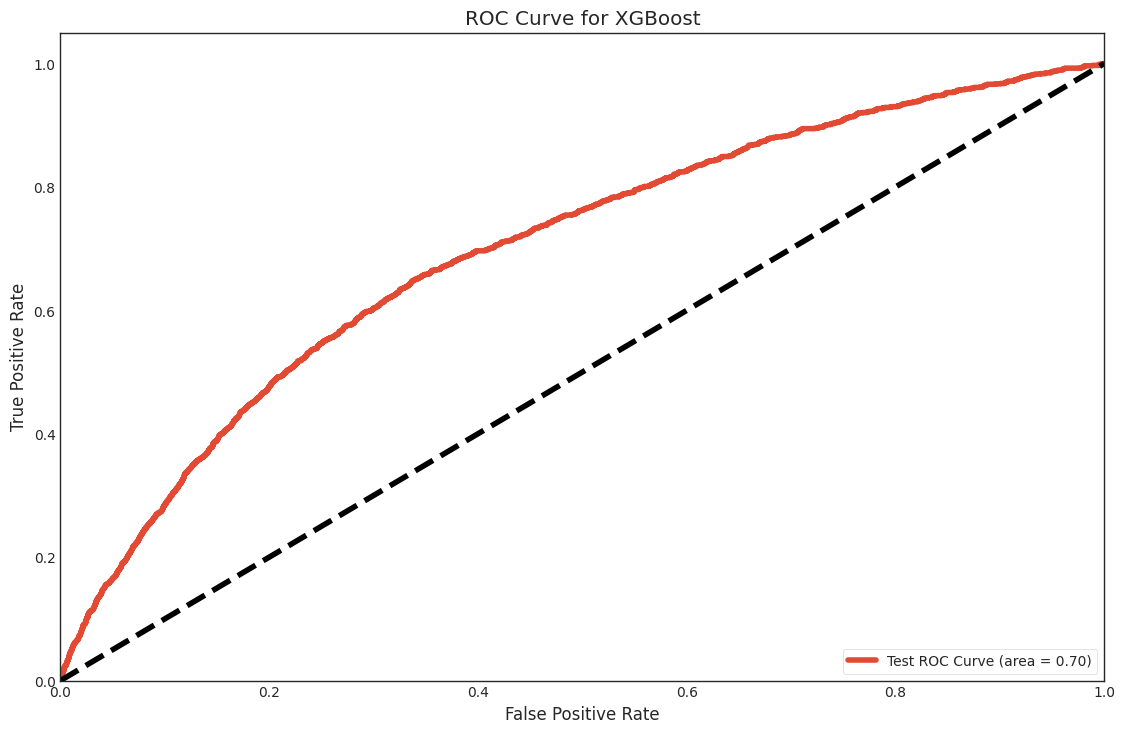

Классификационный отчет для XGBoost на обучающем наборе:
               precision    recall  f1-score   support

         0.0       0.99      0.91      0.95    193359
         1.0       0.25      0.82      0.38      6641

    accuracy                           0.91    200000
   macro avg       0.62      0.87      0.67    200000
weighted avg       0.97      0.91      0.93    200000

Confusion Matrix для XGBoost на обучающем наборе:
 [[176834  16525]
 [  1196   5445]]
ROC AUC для XGBoost на обучающем наборе: 0.9510885469091999


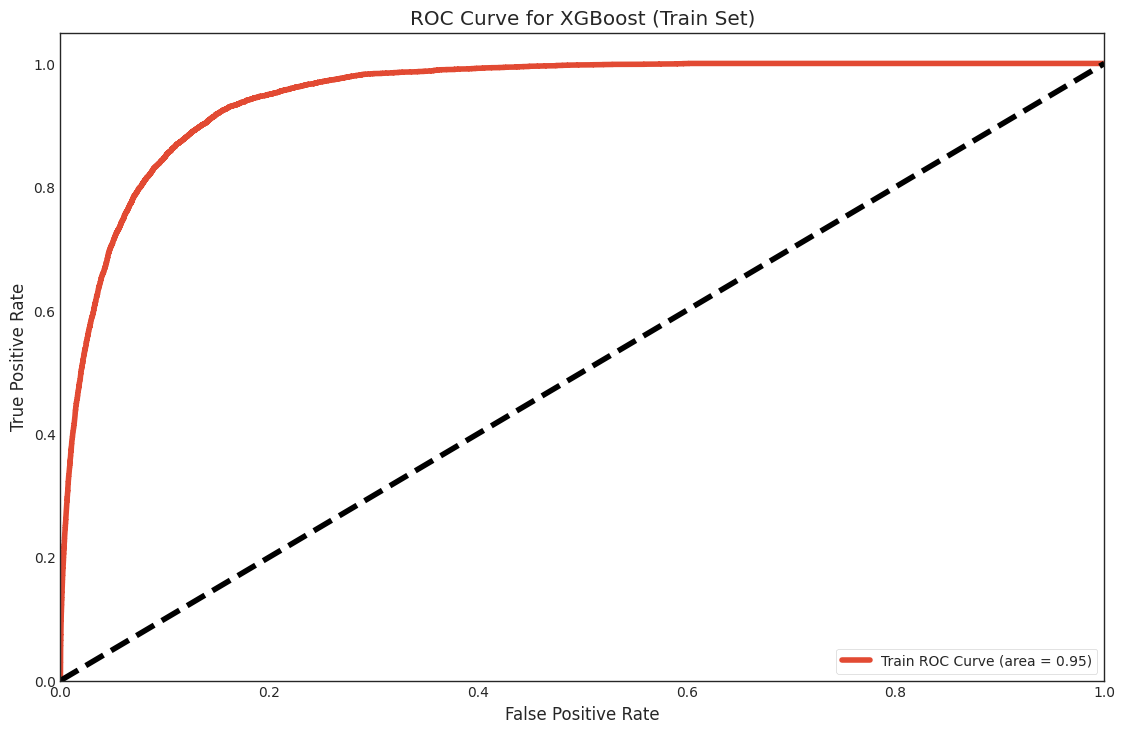

In [139]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve


positive_class_weight = 18

# Создание экземпляра модели XGBClassifier с установленным весом положительного класса
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=positive_class_weight)

# Обучение модели
xgb_model.fit(X_train, y_train)

# Предсказания на тестовом наборе
y_pred_xgb = xgb_model.predict(X_test)

# Вероятности для расчета ROC AUC
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Классификационный отчет
print("Классификационный отчет для XGBoost на тестовом наборе:\n", classification_report(y_test, y_pred_xgb))

# Матрица ошибок
print("Confusion Matrix для XGBoost на тестовом наборе:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC AUC
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC AUC для XGBoost на тестовом наборе:", roc_auc_xgb)

# Построение ROC-кривой
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'Test ROC Curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend(loc="lower right")
plt.show()

# Предсказания на обучающем наборе
y_pred_train_xgb = xgb_model.predict(X_train)

# Вероятности для расчета ROC AUC на обучающем наборе
y_pred_proba_train_xgb = xgb_model.predict_proba(X_train)[:, 1]

# Классификационный отчет для обучающего набора
print("Классификационный отчет для XGBoost на обучающем наборе:\n", classification_report(y_train, y_pred_train_xgb))

# Матрица ошибок для обучающего набора
print("Confusion Matrix для XGBoost на обучающем наборе:\n", confusion_matrix(y_train, y_pred_train_xgb))

# ROC AUC для обучающего набора
roc_auc_train_xgb = roc_auc_score(y_train, y_pred_proba_train_xgb)
print("ROC AUC для XGBoost на обучающем наборе:", roc_auc_train_xgb)

# Построение ROC-кривой для обучающего набора
fpr_train_xgb, tpr_train_xgb, _ = roc_curve(y_train, y_pred_proba_train_xgb)
plt.figure()
plt.plot(fpr_train_xgb, tpr_train_xgb, label=f'Train ROC Curve (area = {roc_auc_train_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (Train Set)')
plt.legend(loc="lower right")
plt.show()


Построим кривые обучения и валидации для оценки лосса на каждом этапе обучения. Если лосс на обучающем наборе продолжает снижаться, тогда как лосс на валидационном наборе начинает увеличиваться, это явный признак переобучения.

<a id="ch0014"></a>
## 14. Выводы по результатам кросс-валидации и результатам логлосса на обучающей и валидационной выборках



В целом, результаты кросс-валидации показывают, что модель XGBoost хорошо обучена и демонстрирует высокую способность различать классы, что делает её подходящей для использования в реальных задачах классификации.

Обучим модель на всем датафрейме

Классификационный отчет для XGBoost на всем наборе данных:
               precision    recall  f1-score   support

         0.0       0.99      0.90      0.95    241788
         1.0       0.22      0.77      0.34      8212

    accuracy                           0.90    250000
   macro avg       0.60      0.84      0.64    250000
weighted avg       0.97      0.90      0.93    250000

Confusion Matrix для XGBoost на всем наборе данных:
 [[218784  23004]
 [  1882   6330]]
ROC AUC для XGBoost на всем наборе данных: 0.9345041122682937


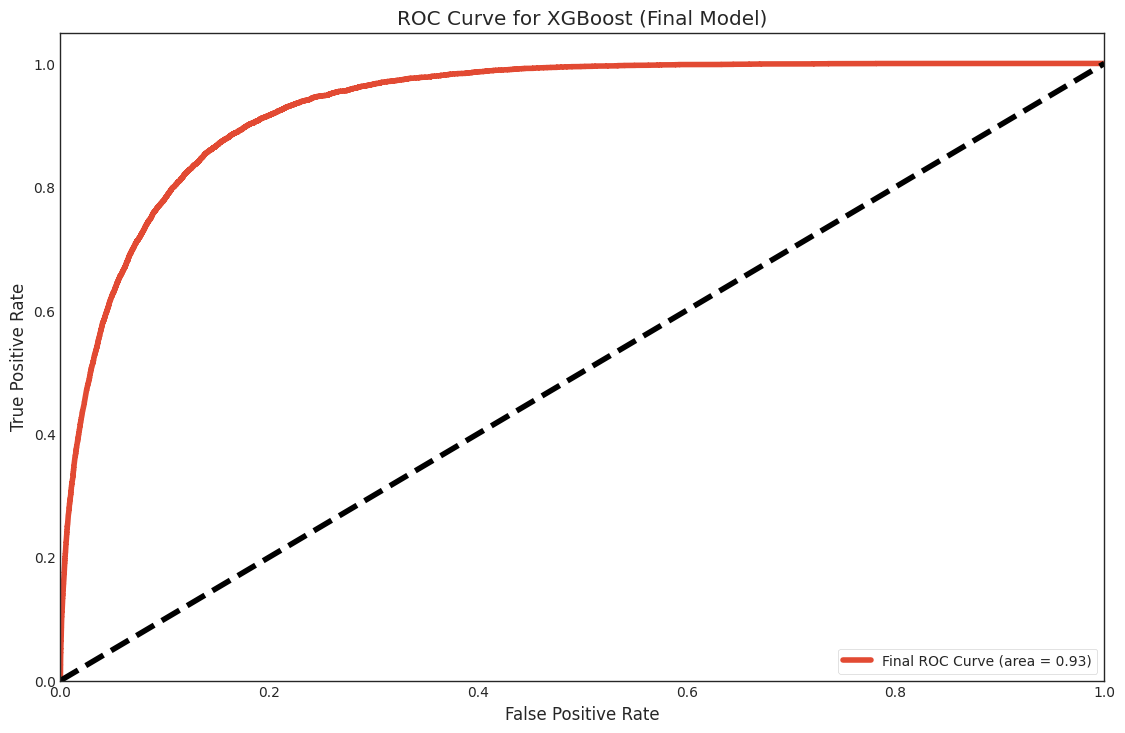

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Создание экземпляра модели XGBClassifier с установленным весом положительного класса
xgb_model_final = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=positive_class_weight)

# Обучение модели на всем наборе данных
xgb_model_final.fit(X, y)

# Предсказания на всем наборе данных
y_pred_final = xgb_model_final.predict(X)

# Вероятности для расчета ROC AUC на всем наборе данных
y_pred_proba_final = xgb_model_final.predict_proba(X)[:, 1]

# Классификационный отчет
print("Классификационный отчет для XGBoost на всем наборе данных:\n", classification_report(y, y_pred_final))

# Матрица ошибок
print("Confusion Matrix для XGBoost на всем наборе данных:\n", confusion_matrix(y, y_pred_final))

# ROC AUC
roc_auc_final = roc_auc_score(y, y_pred_proba_final)
print("ROC AUC для XGBoost на всем наборе данных:", roc_auc_final)

# Построение ROC-кривой
fpr_final, tpr_final, _ = roc_curve(y, y_pred_proba_final)
plt.figure()
plt.plot(fpr_final, tpr_final, label=f'Final ROC Curve (area = {roc_auc_final:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия для сравнения
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost (Final Model)')
plt.legend(loc="lower right")
plt.show()


ROC AUC для XGBoost на всем наборе данных: 0.93, что удовлетворяет требованиям настоящего проекта.